In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats,signal
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable

import os

from PlottingScripts import CV, Spline, Tune1, distVar, distplot_wratio, StackedHisto, SimpleHisto, mcplot, DrawMatrix

from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

Welcome to JupyROOT 6.22/02


In [2]:
datafolder = '../../rootFiles/1mu1p_selection'
auxfolder = '../aux'
tag = '2021-01-21'
plotfolder = '../outputs/PlotDumps'+tag
covfolder = '../outputs/covMatrix'+tag
covtag = 'frac_covar_run3_%s'%tag



RSE  = ['run','subrun','event']

# RUN 3 

In [3]:
run = 'run3'
f_scaleslist = []
s_detsyslist = []
names = ['wiremodX','wiremodYZ','recomb','LYdown','LYAtt','LYRayleigh','SCE','wiremodThetaYZ','wiremodThetaXZ']

for name in names:
    s_detsyslist.append(name)
'''
s_detsyslist.append('wiremodX')
#f_scaleslist.append(1.30915319237e+21) #POT

s_detsyslist.append('wiremodYZ')
#f_scaleslist.append(1.31097060608e+21) #POT

s_detsyslist.append('recomb')
f_scaleslist.append(6.3706245518e+20)

s_detsyslist.append('LYdown')
#f_scaleslist.append(1.21808316832e+21)

s_detsyslist.append('LYRayleigh')
#f_scaleslist.append(1.30830317061e+21)

s_detsyslist.append('SCE')
f_scaleslist.append(5.89862945464e+20)

s_detsyslist.append('wiremodThetaYZ')
#f_scaleslist.append(1.26402704519e+21)

s_detsyslist.append('wiremodThetaXZ')
#f_scaleslist.append(1.29697772584e+21)
'''

#df_cv = pd.read_parquet('../../data/pickles/detsys_CV_run3_nodupesMay1.parquet')
#scaleCV = 9.65858292241e+19 

a_df_sys = []

RSE = ['run','subrun','event']
i=0
for sys in s_detsyslist:
#    print('111')
    df_sys = pd.read_parquet('%s/pickles/%s_%s_%s.parquet'%(datafolder,sys,run,tag))
    print(df_sys.shape[0])
    i+=1
    a_df_sys.append(df_sys)
    print("total %d, cv = %d dv = %d"%(df_sys.shape[0],df_sys.query("isCV==True").shape[0],df_sys.query("isCV==False").shape[0]))
#    print(df_sys.shape[0])

#df_numu_run3_presel = pd.read_parquet('../../data/pickles/numu_run1_nodupesMay1.parquet')
#print((list(a_df_sys[7])))


124884
total 124884, cv = 106578 dv = 18306
125115
total 125115, cv = 106578 dv = 18537
18120
total 18120, cv = 8753 dv = 9367
123356
total 123356, cv = 106578 dv = 16778
123293
total 123293, cv = 106578 dv = 16715
124936
total 124936, cv = 106578 dv = 18358
17797
total 17797, cv = 8753 dv = 9044
124406
total 124406, cv = 106578 dv = 17828
124251
total 124251, cv = 106578 dv = 17673


In [4]:
# Make big list of variables with their accompanying ranges so we can just dump a buttload of plots
#varlistSel = {}

varListSel = {}
varListSel['Xreco'] = distVar('Xreco',(15,241.25),'Reco Vertex X',datafolder+'/'+covfolder+'/'+covtag+'__x_reco.txt')
varListSel['Yreco'] = distVar('Yreco',(-101.5,101.5),'Reco Vertex Y',datafolder+'/'+covfolder+'/'+covtag+'__y_reco.txt')
varListSel['Zreco'] = distVar('Zreco',(15,1021.8),'Reco Vertex Z',datafolder+'/'+covfolder+'/'+covtag+'__z_reco.txt')
varListSel['OpenAng'] = distVar('OpenAng',(.6,2.8),'Opening Angle (rads)',datafolder+'/'+covfolder+'/'+covtag+'__openang_reco.txt')
varListSel['Thetas'] = distVar('Thetas',(0,np.pi),r'Sum of Thetas ($\theta_{p} + \theta_{\mu}$) (rads)',datafolder+'/'+covfolder+'/'+covtag+'__sum_thetas_reco.txt')
varListSel['Phis'] = distVar('Phis',(1.5,4),r'Difference of Phis ($|\phi_{p} - \phi_{\mu}|$)  (rads)',datafolder+'/'+covfolder+'/'+covtag+'__sum_phis_reco.txt')
varListSel['ChargeNearTrunk'] = distVar('ChargeNearTrunk',(0,600),'ADC Charge within 5cm of Reco Vertex',datafolder+'/'+covfolder+'/'+covtag+'__charge_near_trunk_reco.txt')
varListSel['Enu_1m1p'] = distVar('Enu_1m1p',(200,1200),'Reconstructed Neutrino Energy (MeV)',datafolder+'/'+covfolder+'/'+covtag+'__nu_energy_reco.txt')
varListSel['PhiT_1m1p'] = distVar('PhiT_1m1p',(0,1),r'$\phi_T$',datafolder+'/'+covfolder+'/'+covtag+'__phiT_reco.txt')
varListSel['AlphaT_1m1p'] = distVar('AlphaT_1m1p',(0,np.pi),r'$\alpha_T$',datafolder+'/'+covfolder+'/'+covtag+'__alphaT_reco.txt')
varListSel['PT_1m1p'] = distVar('PT_1m1p',(0,320),r'$p_T$',datafolder+'/'+covfolder+'/'+covtag+'__pT_reco.txt')
varListSel['PTRat_1m1p'] = distVar('PTRat_1m1p',(0,.4),r'$p_T/|p|$',datafolder+'/'+covfolder+'/'+covtag+'__pT_ratio_reco.txt')
varListSel['BjXB_1m1p'] = distVar('BjXB_1m1p',(.2,1.8),'Bjorken X*',datafolder+'/'+covfolder+'/'+covtag+'__BjxB_reco.txt')
varListSel['BjYB_1m1p'] = distVar('BjYB_1m1p',(0.05,.75),'Bjorken Y*',datafolder+'/'+covfolder+'/'+covtag+'__BjyB_reco.txt')
varListSel['Q2_1m1p'] = distVar('Q2_1m1p',(0,6e5),r'$Q^2$',datafolder+'/'+covfolder+'/'+covtag+'__Q2_reco.txt')
varListSel['SphB_1m1p'] = distVar('SphB_1m1p',(0,1000),'QE Consistency*',datafolder+'/'+covfolder+'/'+covtag+'__sphB_reco.txt')
varListSel['Q0_1m1p'] = distVar('Q0_1m1p',(70,600),r'$Q_0$',datafolder+'/'+covfolder+'/'+covtag+'__Q0_reco.txt')
varListSel['Q3_1m1p'] = distVar('Q3_1m1p',(200,1000),r'$Q_3$',datafolder+'/'+covfolder+'/'+covtag+'__Q3_reco.txt')
varListSel['Lepton_PhiReco'] = distVar('Lepton_PhiReco',(-np.pi,np.pi),r'Muon $\phi$',datafolder+'/'+covfolder+'/'+covtag+'__lepton_phi_reco.txt')
varListSel['Lepton_ThetaReco'] = distVar('Lepton_ThetaReco',(.2,2.8),r'Muon $\theta$',datafolder+'/'+covfolder+'/'+covtag+'__lepton_theta_reco.txt')
varListSel['Lepton_TrackLength'] = distVar('Lepton_TrackLength',(20,200),'Muon Track Length (cm)',datafolder+'/'+covfolder+'/'+covtag+'__lepton_length_reco.txt')
varListSel['Muon_Edep'] = distVar('Muon_Edep',(50,600),'Reco Muon Energy (from range) (MeV)',datafolder+'/'+covfolder+'/'+covtag+'__lepton_KE_reco.txt')
varListSel['Proton_PhiReco'] = distVar('Proton_PhiReco',(-np.pi,np.pi),r'Proton $\phi$',datafolder+'/'+covfolder+'/'+covtag+'__proton_phi_reco.txt')
varListSel['Proton_ThetaReco'] = distVar('Proton_ThetaReco',(0,2),r'Proton $\theta$',datafolder+'/'+covfolder+'/'+covtag+'__proton_theta_reco.txt')
varListSel['Proton_TrackLength'] = distVar('Proton_TrackLength',(5,100),'Proton Track Length',datafolder+'/'+covfolder+'/'+covtag+'__proton_length_reco.txt')
varListSel['Proton_Edep'] = distVar('Proton_Edep',(50,500),'Reco Proton Energy (from range) (MeV)',datafolder+'/'+covfolder+'/'+covtag+'__proton_KE_reco.txt')
varListSel['Proton_CosTheta'] = distVar('Proton_CosTheta',(0,1),'Proton Cos Theta',datafolder+'/'+covfolder+'/'+covtag+'__proton_cos_theta_reco.txt')
varListSel['Lepton_CosTheta'] = distVar('Lepton_CosTheta',(-1,1),'Muon Cos Theta',datafolder+'/'+covfolder+'/'+covtag+'__lepton_cos_theta_reco.txt')
varListSel['MPID_eminus'] = distVar('MPID_eminus',(0,1),'Eminus MPID',datafolder+'/'+covfolder+'/'+covtag+'__mpid_eminus_score.txt')
varListSel['MPID_muon'] = distVar('MPID_muon',(0,1),'Muon MPID',datafolder+'/'+covfolder+'/'+covtag+'__mpid_muon_score.txt')
varListSel['MPID_proton'] = distVar('MPID_proton',(0,1),'Proton MPID',datafolder+'/'+covfolder+'/'+covtag+'__mpid_proton_score.txt')
varListSel['MPID_gamma'] = distVar('MPID_gamma',(0,1),'Gamma MPID',datafolder+'/'+covfolder+'/'+covtag+'__mpid_gamma_score.txt')
varListSel['MPID_pion'] = distVar('MPID_pion',(0,1),'Pion MPID',datafolder+'/'+covfolder+'/'+covtag+'__mpid_pion_score.txt')



In [5]:
a_cv_sys = []
a_overlap_sys = []
for df in a_df_sys:
    #df.insert(0,'bdt_run3_cosmic',bdt_run3_cosmic.predict_proba(df[myvars].values.tolist())[:,0])
    #df.insert(0,'bdt_run3_nu',bdt_run3_nu.predict_proba(df[myvars].values.tolist())[:,0])
#    df.insert(0,'bkgBDT_run3',bkgBDT_run3.predict_proba(df[myvars].values.tolist())[:,0])
#    df.insert(0,'bkgBDT_run3_cv',bkgBDT_run3.predict_proba(df[myvars_cv].values.tolist())[:,0])
#    df.insert(0,'Lepton_CosTheta',np.cos(df['Lepton_ThetaReco'].values).tolist())
#    df.insert(0,'Proton_CosTheta',np.cos(df['Proton_ThetaReco'].values).tolist())
#    df.insert(0,'Lepton_CosTheta_cv',np.cos(df['Lepton_ThetaReco_cv'].values).tolist())
#    df.insert(0,'Proton_CosTheta_cv',np.cos(df['Proton_ThetaReco_cv'].values).tolist())
    a_cv_sys.append(df.sort_values('BDTscore_1mu1p_nu',ascending=True).drop_duplicates(RSE).sort_index().query('Enu_1m1p > 0'))
    a_overlap_sys.append(df.sort_values('BDTscore_1mu1p_nu',ascending=True).drop_duplicates(RSE).sort_index().query('Enu_1m1p > 0'))
    
#df_numu_run3_presel.insert(0,'bdt_run3_cosmic',bdt_run3_cosmic.predict_proba(df_numu_run3_presel[myvars].values.tolist())[:,0])
#df_numu_run3_presel.insert(0,'bdt_run3_nu',bdt_run3_nu.predict_proba(df_numu_run3_presel[myvars].values.tolist())[:,0])
       
#df_cv.insert(0,'bdt_run3_cosmic',bdt_run3_cosmic.predict_proba(df_cv[myvars].values.tolist())[:,0])
#df_cv.insert(0,'bdt_run3_nu',bdt_run3_nu.predict_proba(df_cv[myvars].values.tolist())[:,0])
#df_cv.insert(0,'bkgBDT_run3',bkgBDT_run3.predict_proba(df_cv[myvars].values.tolist())[:,0])
#df_cv.insert(0,'Lepton_CosTheta_cv',np.cos(df_cv['Lepton_ThetaReco'].values).tolist())
#df_cv.insert(0,'Proton_CosTheta_cv',np.cos(df_cv['Proton_ThetaReco'].values).tolist())

    

In [6]:
###################### Not Importnat ##################33

# Dump the detsys array for easier cov calculation
pickle.dump((a_overlap_sys,a_cv_sys,s_detsyslist),open("../../data/CovMatrices/detsyspack_jul2.pickle", "wb" ),protocol=2)

# Build Covariance Matrices!

In [5]:
# define cuts
Ecut = 'Enu_1m1p > 200'
precuts = 'PassPrecuts1m1p==1'
bdtcuts = 'BDTscore_1mu1p_nu < .4'
morecuts = 'Proton_CosTheta > 0'
bonuscuts = '(MPID_proton > .9 or Enu_1m1p > 400)'
#bdtcuts = 'bdt_run3_cosmic < .5 and bdt_run3_nu < .5'
s_cuts = bonuscuts + ' and ' + Ecut + ' and ' +  bdtcuts + ' and ' +  morecuts + ' and ' +  'isCV ==False'
s_cuts_cv = bonuscuts + ' and '+ Ecut + ' and ' +  bdtcuts + ' and ' +  morecuts + ' and ' +  'isCV ==True' 

nbins = 10

In [6]:
#Bring in the required modules
from scipy import *
from scipy import signal
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from scipy.fftpack import fft, fftfreq
from scipy.signal import lfilter
import scipy.signal
from scipy.optimize import leastsq
import pandas as pd
import scipy.stats as stats
import matplotlib.mlab as mlab
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.utils.fixes import parse_version
from random import random




def smooth(cv_list,dv_list,xmin,xmax,dv_name,ratio=1,nbin=20):
    
#----------------------------------------------------------------
# This section is the CV
    cv = np.array(cv_list)
    dv = np.array(dv_list)

# throw away the data points outside of the hist limits to fake the real data
#    mask1 = np.logical_and(cv >= xmin, cv <= xmax)
#    cv = cv[mask1]
        
    cv_hist, binedges = np.histogram(cv, bins = nbin, range = (xmin, xmax))
    cv_hist= cv_hist+0.000001 # assure no zero bins    
    print('$$$$$$$$$$$$$$$$$$$$')
    print(cv_hist)
    print('!!!!!!!!!!!!!!!!!!!!')

#-------------------------------------------------------------------------------
# look for spikes at edges and remove them.  Smoothing cannot handle these.
    
    # flags for bin drops
    drop0=False
    dropn=False
    
    # throw away the first bin if needed
    # do this if the change is more than 80%
    print('cv[0] =  %f    cv[1] = %f  rat = %f'%(cv[0],cv[1],cv[0]/(cv[0]+cv[1])))

#    if ((cv_hist[0]/(cv_hist[0]+cv_hist[1]))>0.80):
#        drop0=True

    if ((cv_hist[nbin-1]/(cv_hist[nbin-2]+cv_hist[nbin-1]))>0.80):
        dropn=True


    # throw away the firstand/or last bin if needed
        
    if (drop0):    
        mask1 = np.logical_and(cv >= binedges[1], cv <= xmax)
        cv = cv[mask1]
        print('----------------------------drop0_cv')
        
    if (dropn):
        mask1 = np.logical_and(cv >= xmin, cv <=  binedges[nbin-1])
        cv = cv[mask1]
        print('dropn_cv')
    
        
    #-------------------------------------------------------------------------------
# CV smoothing, calculate the bandwidth for use throughout
        
        
# calculate Sheather/Jones bandwidth
    bwid=0.5*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
    print('bwid = %f'%bwid)
    
    # This smoothing library wants 2d so pad it out
    cv2d=cv [:, np.newaxis]

    myrange = (lambda edges: (edges[:-1] + edges[1:])/2.0)(np.linspace(xmin,xmax,(10*nbin)+1))
    range2d=myrange [:, np.newaxis]
#    print(myrange)

#----------------------------------------------------------------
# This section is the detvar

#
# Create Fake data np.histograms,aiming for about 4000 events in the np.histogram
#
    # This smoothing library wants 2d so pad it out
    dv2d=dv [:, np.newaxis]
    dv_hist, binedges = np.histogram(dv, bins = nbin, range = (xmin, xmax))
    dv_hist= ratio*dv_hist+0.000001 # assure no zero bins    
    print('!!!!!!!!!!!!!!!!!!!!')
    print(dv_hist)
    print('!!!!!!!!!!!!!!!!!!!!')

    # throw away the firstand/or last bin if needed
        
    if (drop0):    
        mask1 = np.logical_and(dv >= binedges[1], dv <= xmax)
        dv = dv[mask1]
        print('-----------------------------------drop0_dv')

        
    if (dropn):
        mask1 = np.logical_and(dv >= xmin, dv <=  binedges[nbin-1])
        dv = dv[mask1]
        print('drop0_dv')
    
     
#----------------------------------------------------------------
# Smooth both CV AND DV, Fix up the edge bins.
         
    #get the CV smoothed case and normalize it
    gkdeCV= KernelDensity(kernel='epanechnikov', bandwidth=bwid).fit(cv2d)
    mykdeCV = np.exp(gkdeCV.score_samples(range2d))
    yhatCV=np.zeros(10*nbin)
#    yhatCV=(mykdeCV)*(cv.shape[0])/sum(mykdeCV)
    yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)

    #get the DV smoothed case and normalize it
    gkdeDV= KernelDensity(kernel='epanechnikov', bandwidth=bwid).fit(dv2d)
    mykdeDV = np.exp(gkdeDV.score_samples(range2d))

    yhatDV=np.zeros(10*nbin)
#    yhatDV=(mykdeDV)*dv.shape[0]/sum(mykdeDV)
    yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)

       
    # rebin the ratio into the bins we will use by summing the bin...
    smoothrat=np.zeros(nbin)
    smoothCV=np.zeros(nbin)
    smoothDV=np.zeros(nbin)

    k=0
    
    for j in range(nbin):
        ratvalCV=0.
        ratvalDV=0.
        for n in range(10):
            ratvalCV+=yhatCV[k]
            ratvalDV+=yhatDV[k]
            k+=1
        smoothrat[j]=ratvalDV/ratvalCV
        smoothCV[j]=ratvalCV
        smoothDV[j]=ratvalDV
    
    
        # put the first and/or last bin back if needed
    if (drop0):
        smoothrat[0]=dv_hist[0]/cv_hist[0]
    if (dropn):
        smoothrat[nbin-1]=dv_hist[nbin-1]/cv_hist[nbin-1]
    
    
    
    
    offset = (xmax - xmin )/(2*nbin)
    x= np.linspace(xmin+offset,xmax-offset,nbin)
    
    plt.plot(x, cv_hist, linewidth=1, linestyle="-", c="b",label='cv')  # smooth by filter
    plt.plot(x, dv_hist, linewidth=1, linestyle="-", c="g",label='dv')  # smooth by filter

    plt.plot(x, smoothCV, linewidth=1, linestyle="--", c="b",label='cv_smooth')  # smooth by filter

    plt.plot(x, smoothDV, linewidth=1, linestyle="--", c="g",label='dv_smooth')  # smooth by filter
    plt.legend()
    plt.title(dv_name)
    plt.savefig(plotfolder+'/detsys_%s_%s_%s_full_hists.png'%(dist.myname, run,dv_name),dpi=120,bbox_inches='tight')
    
    plt.show()
    
    
    plt.plot(x, dv_hist/cv_hist, linewidth=1, linestyle="-", c="b",label='original')  # smooth by filter
    plt.plot(x,smoothrat , linewidth=1, linestyle="-", c="m",label='smoothed')  # smooth by filter
    plt.legend()
    plt.title(dv_name)

    plt.savefig(plotfolder+'/detsys_%s_%s_%s_ratio.png'%(dist.myname, run,dv_name),dpi=120,bbox_inches='tight')

    plt.show()


    return(smoothCV,smoothDV)


9
0
cv = 4424  and dv = 6065
cv POT = 898773223801000034304.000000 dv POT = 1309153192370000101376.000000
$$$$$$$$$$$$$$$$$$$$
[  2.000001   4.000001  29.000001  42.000001 102.000001  84.000001
 134.000001 199.000001 256.000001 343.000001 416.000001 355.000001
 375.000001 303.000001 279.000001 287.000001 199.000001 156.000001
 155.000001 116.000001]
!!!!!!!!!!!!!!!!!!!!
cv[0] =  400.276123    cv[1] = 1264.675878  rat = 0.240413
bwid = 138.429884
!!!!!!!!!!!!!!!!!!!!
[  3.43265208   4.80571251  25.40161899  48.74364633  74.83179453
  77.5779154  122.20237943 166.82684346 243.03169743 306.87900751
 366.60713629 356.30918305 340.51898809 308.93859815 280.7908593
 255.38924131 193.60152188 159.27501109 131.81380245 105.03912403]
!!!!!!!!!!!!!!!!!!!!


<ipython-input-6-2c3e09da2077>:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.5*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-6-2c3e09da2077>:121: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-6-2c3e09da2077>:129: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


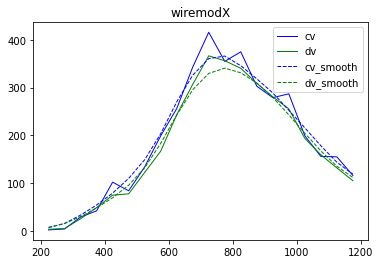

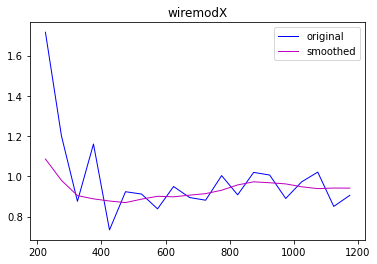

Enu_1m1p [0.00746162 0.0003985  0.00918085 0.01253197 0.01504646 0.01701802
 0.01287638 0.00985549 0.01036626 0.00876043 0.00739935 0.00477426
 0.00182354 0.00074312 0.00101813 0.00141253 0.00270124 0.00371995
 0.0033947  0.0034252 ]
Enu_1m1p [5.13122279e-01 4.05731900e-02 1.53963771e-02 2.57804718e-02
 7.09449676e-02 5.84512238e-03 7.75138531e-03 2.61385335e-02
 2.56617580e-03 1.10899895e-02 1.40974892e-02 1.36001400e-05
 8.45468623e-03 3.84133758e-04 4.12015963e-05 1.21312645e-02
 7.35930324e-04 4.40733526e-04 2.23766828e-02 8.92842033e-03]


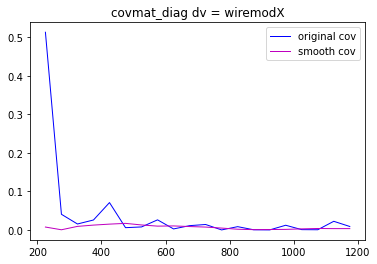

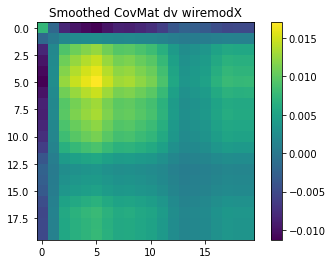

1
cv = 4424  and dv = 6107
cv POT = 898773223801000034304.000000 dv POT = 1310970606080000000000.000000
$$$$$$$$$$$$$$$$$$$$
[  2.000001   4.000001  29.000001  42.000001 102.000001  84.000001
 134.000001 199.000001 256.000001 343.000001 416.000001 355.000001
 375.000001 303.000001 279.000001 287.000001 199.000001 156.000001
 155.000001 116.000001]
!!!!!!!!!!!!!!!!!!!!
cv[0] =  400.276123    cv[1] = 1264.675878  rat = 0.240413
bwid = 138.429884
!!!!!!!!!!!!!!!!!!!!
[  6.85578571   6.85578571  23.99524749  45.24818009  73.35689741
  73.35689741 112.43487026 169.33788337 245.43709366 333.19113796
 375.0114247  348.9594428  342.10365809 292.74200817 277.6592818
 264.63329085 189.21965903 157.68304936 139.17243064 112.43487026]
!!!!!!!!!!!!!!!!!!!!


<ipython-input-6-2c3e09da2077>:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.5*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-6-2c3e09da2077>:121: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-6-2c3e09da2077>:129: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


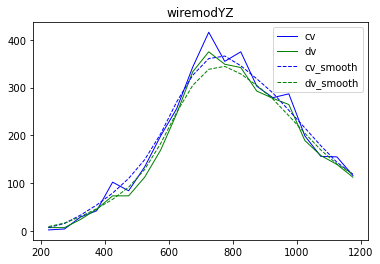

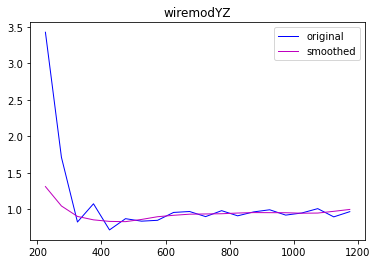

Enu_1m1p [9.80400131e-02 2.23678761e-03 9.22314358e-03 2.03981677e-02
 2.69407554e-02 2.80782623e-02 1.88415059e-02 1.00080361e-02
 6.48067531e-03 4.25125540e-03 3.87862581e-03 3.49222219e-03
 2.45190615e-03 1.87212557e-03 1.96453639e-03 2.04281869e-03
 2.70558726e-03 2.47997916e-03 6.76945685e-04 6.00143576e-08]
Enu_1m1p [5.89466129e+00 5.09719145e-01 2.97830650e-02 5.98110398e-03
 7.88569188e-02 1.60538058e-02 2.58996917e-02 2.22176516e-02
 1.70249956e-03 8.17803756e-04 9.70820652e-03 2.89532580e-04
 7.69542668e-03 1.14614490e-03 2.30923031e-05 6.07351944e-03
 2.41547156e-03 1.16397591e-04 1.04271377e-02 9.44571728e-04]


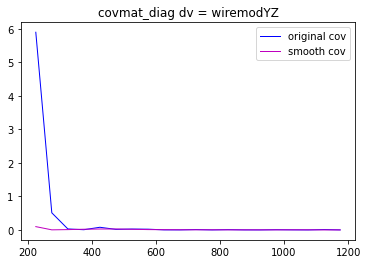

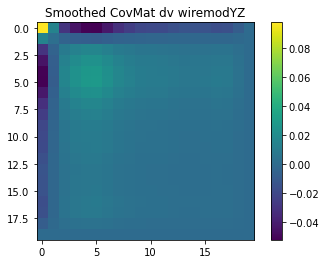

2
cv = 2953  and dv = 3220
cv POT = 579534847420999991296.000000 dv POT = 637062455184000024576.000000
$$$$$$$$$$$$$$$$$$$$
[  3.000001   3.000001  25.000001  46.000001 108.000001 148.000001
 152.000001 203.000001 202.000001 224.000001 219.000001 218.000001
 186.000001 164.000001 135.000001 136.000001 117.000001 117.000001
  84.000001  75.000001]
!!!!!!!!!!!!!!!!!!!!
cv[0] =  955.931593    cv[1] = 1037.957870  rat = 0.479431
bwid = 146.622301
!!!!!!!!!!!!!!!!!!!!
[1.00000000e-06 1.81939827e+00 2.27424669e+01 5.82207138e+01
 1.01886248e+02 1.31906303e+02 1.60106961e+02 1.81939728e+02
 2.08320989e+02 2.21056770e+02 2.01953099e+02 1.99224003e+02
 2.07411290e+02 1.68294249e+02 1.45551783e+02 1.36454797e+02
 1.20989920e+02 1.05525043e+02 8.27825770e+01 5.82207138e+01]
!!!!!!!!!!!!!!!!!!!!


<ipython-input-6-2c3e09da2077>:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.5*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-6-2c3e09da2077>:121: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-6-2c3e09da2077>:129: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


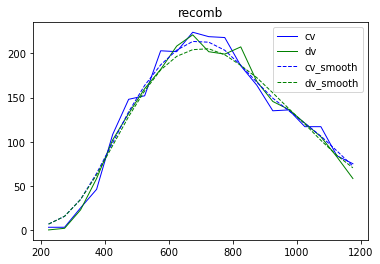

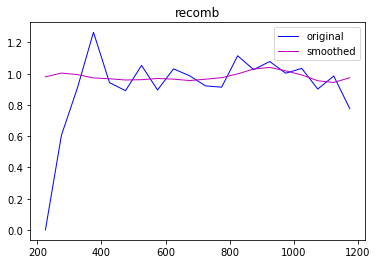

Enu_1m1p [3.89936559e-04 1.84236881e-05 2.83683484e-05 7.21958793e-04
 1.04123583e-03 1.60322416e-03 1.45633055e-03 9.30260525e-04
 1.20009408e-03 1.89330911e-03 1.23009762e-03 6.37775178e-04
 9.47515546e-07 9.15320706e-04 1.63859084e-03 3.37044147e-04
 5.88626046e-05 2.02857514e-03 3.11186961e-03 6.66456444e-04]
Enu_1m1p [1.00000000e+00 1.54869199e-01 8.15433609e-03 7.05793106e-02
 3.20455856e-03 1.18246485e-02 2.84465042e-03 1.07630634e-02
 9.79190492e-04 1.72644479e-04 6.05902472e-03 7.41810698e-03
 1.32513386e-02 6.85624821e-04 6.10919633e-03 1.11829070e-05
 1.16293753e-03 9.61901253e-03 2.10051189e-04 5.00523518e-02]


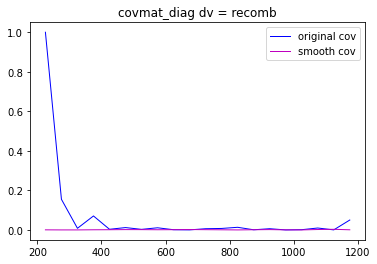

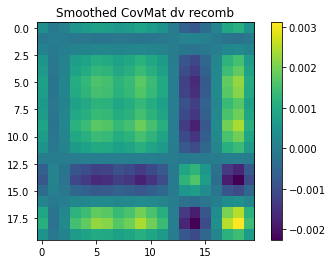

3
cv = 4424  and dv = 5609
cv POT = 898773223801000034304.000000 dv POT = 1218083168320000098304.000000
$$$$$$$$$$$$$$$$$$$$
[  2.000001   4.000001  29.000001  42.000001 102.000001  84.000001
 134.000001 199.000001 256.000001 343.000001 416.000001 355.000001
 375.000001 303.000001 279.000001 287.000001 199.000001 156.000001
 155.000001 116.000001]
!!!!!!!!!!!!!!!!!!!!
cv[0] =  400.276123    cv[1] = 1264.675878  rat = 0.240413
bwid = 138.429884
!!!!!!!!!!!!!!!!!!!!
[  5.16501167   5.16501167  27.30077171  43.5336624   73.78586778
  89.2808998  105.51379049 166.75605991 244.23122003 325.39567348
 371.88076955 349.74500952 326.87139082 312.11421746 265.62912139
 263.41554539 187.41610261 155.6881799  141.66886521 107.72736649]
!!!!!!!!!!!!!!!!!!!!


<ipython-input-6-2c3e09da2077>:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.5*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-6-2c3e09da2077>:121: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-6-2c3e09da2077>:129: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


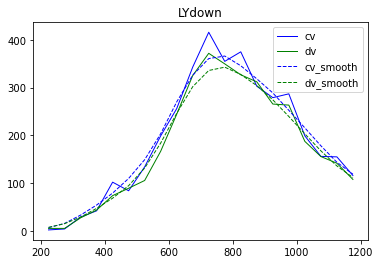

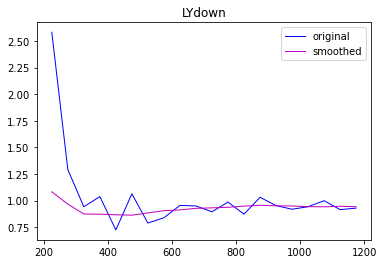

Enu_1m1p [0.00673259 0.00115269 0.01605711 0.01654084 0.01807471 0.01901341
 0.01370744 0.00918446 0.00783555 0.00543039 0.00476926 0.00405719
 0.00277381 0.00200315 0.00249801 0.00264508 0.0033718  0.0035295
 0.00292311 0.00341468]
Enu_1m1p [2.50432314e+00 8.48281170e-02 3.43327014e-03 1.33339982e-03
 7.65126214e-02 3.95236566e-03 4.51918127e-02 2.62536738e-02
 2.11340646e-03 2.63421149e-03 1.12478422e-02 2.19122678e-04
 1.64719155e-02 9.04801727e-04 2.29673850e-03 6.75286268e-03
 3.38846751e-03 3.99541419e-06 7.39726041e-03 5.08594543e-03]


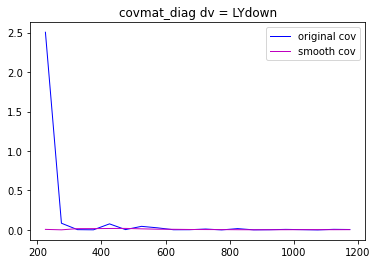

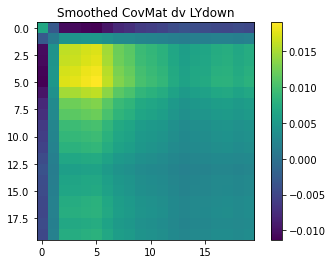

4
cv = 4424  and dv = 5608
cv POT = 898773223801000034304.000000 dv POT = 1212833087030000091136.000000
$$$$$$$$$$$$$$$$$$$$
[  2.000001   4.000001  29.000001  42.000001 102.000001  84.000001
 134.000001 199.000001 256.000001 343.000001 416.000001 355.000001
 375.000001 303.000001 279.000001 287.000001 199.000001 156.000001
 155.000001 116.000001]
!!!!!!!!!!!!!!!!!!!!
cv[0] =  400.276123    cv[1] = 1264.675878  rat = 0.240413
bwid = 138.429884
!!!!!!!!!!!!!!!!!!!!
[  3.70526446   3.70526446  28.90105598  40.01684636  76.32842825
  84.48000786  97.81895631 167.47790934 252.69896889 329.02739614
 393.49898033 347.55371344 326.06318538 306.79581539 268.26107542
 258.62739042 198.60212239 151.17475012 144.50527589 103.74737785]
!!!!!!!!!!!!!!!!!!!!


<ipython-input-6-2c3e09da2077>:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.5*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-6-2c3e09da2077>:121: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-6-2c3e09da2077>:129: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


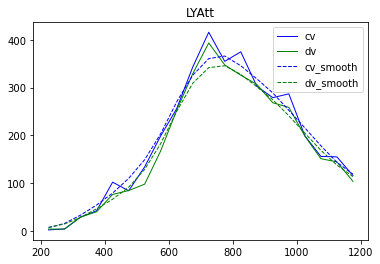

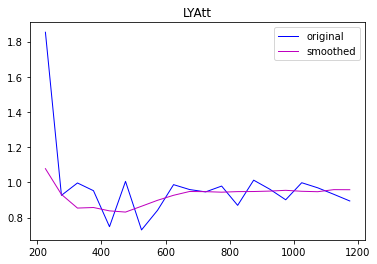

Enu_1m1p [0.00606518 0.00467975 0.02129188 0.02037875 0.02617787 0.0284596
 0.01837171 0.01035571 0.00537439 0.00268169 0.00277062 0.00310191
 0.00275404 0.00269881 0.00245175 0.00203666 0.00256266 0.00280808
 0.00170568 0.00173954]
Enu_1m1p [7.26980866e-01 5.42935179e-03 1.16410431e-05 2.22953648e-03
 6.33438723e-02 3.26539947e-05 7.29042100e-02 2.50913427e-02
 1.66272171e-04 1.65945895e-03 2.92561906e-03 4.39969835e-04
 1.70297737e-02 1.56936759e-04 1.48153958e-03 9.77315532e-03
 3.99756033e-06 9.56732662e-04 4.58436025e-03 1.11568649e-02]


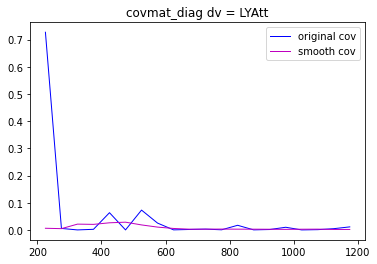

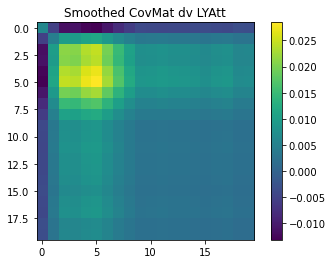

5
cv = 4424  and dv = 6165
cv POT = 898773223801000034304.000000 dv POT = 1308303170610000035840.000000
$$$$$$$$$$$$$$$$$$$$
[  2.000001   4.000001  29.000001  42.000001 102.000001  84.000001
 134.000001 199.000001 256.000001 343.000001 416.000001 355.000001
 375.000001 303.000001 279.000001 287.000001 199.000001 156.000001
 155.000001 116.000001]
!!!!!!!!!!!!!!!!!!!!
cv[0] =  400.276123    cv[1] = 1264.675878  rat = 0.240413
bwid = 138.429884
!!!!!!!!!!!!!!!!!!!!
[  5.49581111   5.49581111  26.79207528  48.08833945  76.94134252
  79.00227131 114.03806076 168.30918558 256.24214732 342.11418027
 379.21089851 357.22765807 342.11418027 294.71281808 283.0342216
 270.66864886 191.66637854 153.88268405 147.69989767 114.72503702]
!!!!!!!!!!!!!!!!!!!!


<ipython-input-6-2c3e09da2077>:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.5*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-6-2c3e09da2077>:121: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-6-2c3e09da2077>:129: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


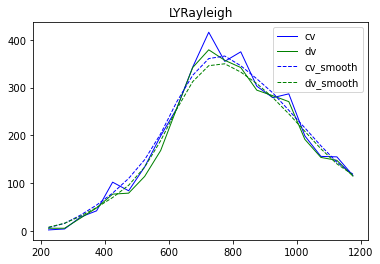

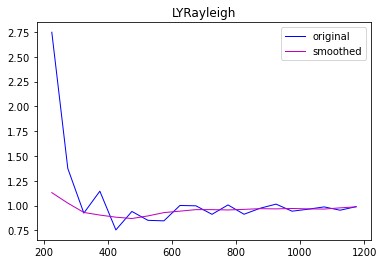

Enu_1m1p [0.01696498 0.00060312 0.00481776 0.00921429 0.01372159 0.01704949
 0.01094299 0.00506874 0.00317586 0.00169375 0.00169307 0.00197187
 0.00147798 0.00098863 0.0011324  0.00086923 0.00112934 0.00125092
 0.00054134 0.00016679]
Enu_1m1p [3.05517208e+00 1.39840493e-01 5.79659451e-03 2.10135290e-02
 6.03552830e-02 3.53986707e-03 2.21919725e-02 2.37854133e-02
 8.94696679e-07 6.66965602e-06 7.82080981e-03 3.93767588e-05
 7.69050457e-03 7.48046495e-04 2.09079224e-04 3.23802720e-03
 1.35809748e-03 1.84213966e-04 2.21816893e-03 1.20803593e-04]


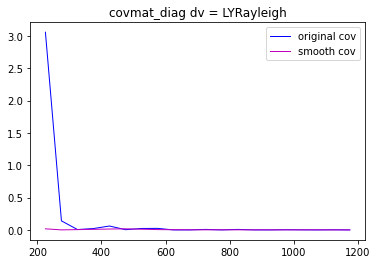

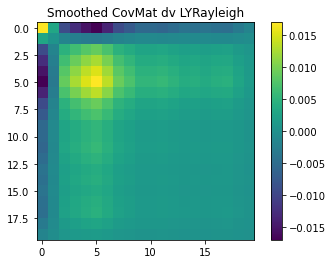

6
cv = 2953  and dv = 3006
cv POT = 579534847420999991296.000000 dv POT = 589862945463999987712.000000
$$$$$$$$$$$$$$$$$$$$
[  3.000001   3.000001  25.000001  46.000001 108.000001 148.000001
 152.000001 203.000001 202.000001 224.000001 219.000001 218.000001
 186.000001 164.000001 135.000001 136.000001 117.000001 117.000001
  84.000001  75.000001]
!!!!!!!!!!!!!!!!!!!!
cv[0] =  955.931593    cv[1] = 1037.957870  rat = 0.479431
bwid = 146.622301
!!!!!!!!!!!!!!!!!!!!
[  0.98249168   0.98249168  20.63230532  51.08951645  87.44167167
 152.28605667 168.98839826 184.70824917 211.23549757 228.92032984
 210.25300689 204.3580628  193.5506653  157.19851008 172.91836099
 148.35609394 118.88137349 115.93390145  78.59925554  62.87940463]
!!!!!!!!!!!!!!!!!!!!


<ipython-input-6-2c3e09da2077>:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.5*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-6-2c3e09da2077>:121: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-6-2c3e09da2077>:129: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


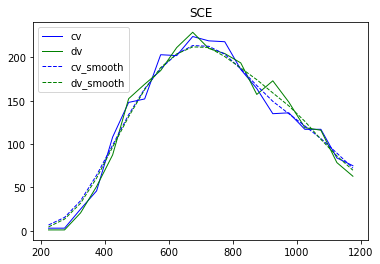

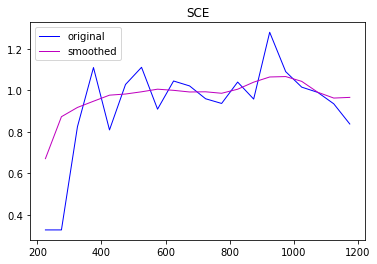

Enu_1m1p [1.08045716e-01 1.59943598e-02 6.69694019e-03 2.68841860e-03
 5.09422243e-04 2.91983409e-04 4.00560060e-05 3.93111958e-05
 4.98645319e-07 5.21054691e-05 4.01415858e-05 1.80909389e-04
 3.67804763e-05 1.60668196e-03 4.23912695e-03 4.50429274e-03
 1.93298499e-03 7.25079248e-05 1.33694214e-03 1.10989383e-03]
Enu_1m1p [4.52260428e-01 4.52260428e-01 3.05228249e-02 1.22415726e-02
 3.62349884e-02 8.38672078e-04 1.24915877e-02 8.11929882e-03
 2.09034401e-03 4.82494339e-04 1.59525252e-03 3.91596831e-03
 1.64795154e-03 1.71996872e-03 7.88917434e-02 8.25438110e-03
 2.58569833e-04 8.30278516e-05 4.13379415e-03 2.61171300e-02]


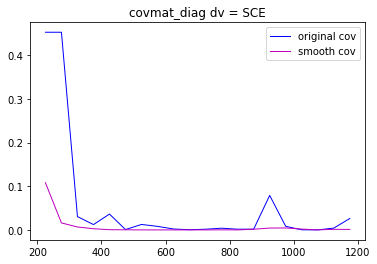

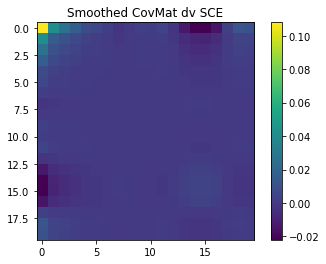

7
cv = 4424  and dv = 5902
cv POT = 898773223801000034304.000000 dv POT = 1264027045189999919104.000000
$$$$$$$$$$$$$$$$$$$$
[  2.000001   4.000001  29.000001  42.000001 102.000001  84.000001
 134.000001 199.000001 256.000001 343.000001 416.000001 355.000001
 375.000001 303.000001 279.000001 287.000001 199.000001 156.000001
 155.000001 116.000001]
!!!!!!!!!!!!!!!!!!!!
cv[0] =  400.276123    cv[1] = 1264.675878  rat = 0.240413
bwid = 138.429884
!!!!!!!!!!!!!!!!!!!!
[  4.26623831   4.97727786  28.44158308  49.77276963  73.9481144
  75.3701935  109.50009199 177.75988897 238.90929044 333.47755084
 368.31848888 369.74056799 325.65611577 290.81517773 290.81517773
 256.68527924 184.15924494 153.58454421 148.60726735 110.21113154]
!!!!!!!!!!!!!!!!!!!!


<ipython-input-6-2c3e09da2077>:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.5*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-6-2c3e09da2077>:121: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-6-2c3e09da2077>:129: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


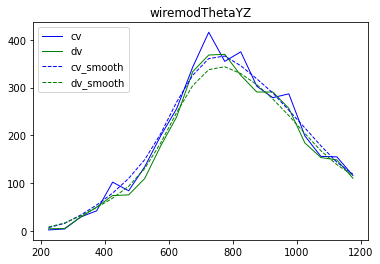

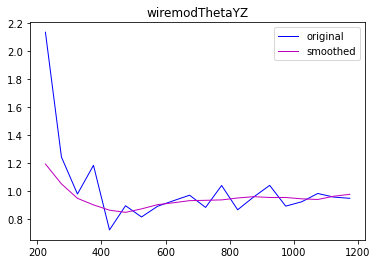

Enu_1m1p [0.03782452 0.00281556 0.00249382 0.00933748 0.01807051 0.02246264
 0.01567249 0.00904878 0.00664725 0.00442507 0.0041128  0.00374863
 0.00225947 0.00145668 0.00192737 0.00193599 0.0028661  0.00338958
 0.00122925 0.00046023]
Enu_1m1p [1.28395789e+00 5.96918792e-02 3.70785467e-04 3.42493947e-02
 7.56351732e-02 1.05546453e-02 3.34286891e-02 1.13921961e-02
 4.45697613e-03 7.70742268e-04 1.31375196e-02 1.72413660e-03
 1.73142685e-02 1.61716083e-03 1.79337882e-03 1.11568959e-02
 5.56167875e-03 2.39744884e-04 1.70102158e-03 2.49041391e-03]


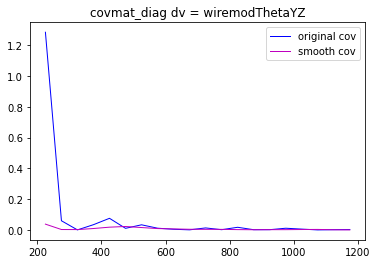

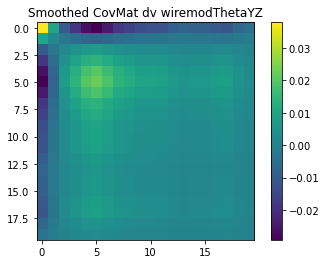

8
cv = 4424  and dv = 5926
cv POT = 898773223801000034304.000000 dv POT = 1296977725840000024576.000000
$$$$$$$$$$$$$$$$$$$$
[  2.000001   4.000001  29.000001  42.000001 102.000001  84.000001
 134.000001 199.000001 256.000001 343.000001 416.000001 355.000001
 375.000001 303.000001 279.000001 287.000001 199.000001 156.000001
 155.000001 116.000001]
!!!!!!!!!!!!!!!!!!!!
cv[0] =  400.276123    cv[1] = 1264.675878  rat = 0.240413
bwid = 138.429884
!!!!!!!!!!!!!!!!!!!!
[  5.54380152   3.46487632  24.94710334  45.73635529  79.69213347
  76.92023321 117.80576204 152.45451529 241.84829867 327.08423166
 358.26810958 342.32968308 321.54043114 300.75117919 263.33052568
 264.02350075 181.55946802 165.62104152 139.98096412 109.49006126]
!!!!!!!!!!!!!!!!!!!!


<ipython-input-6-2c3e09da2077>:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.5*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-6-2c3e09da2077>:121: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-6-2c3e09da2077>:129: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


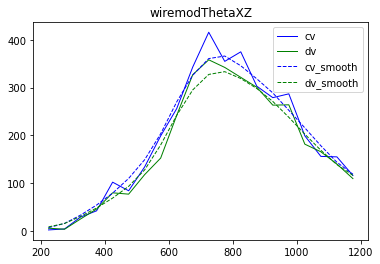

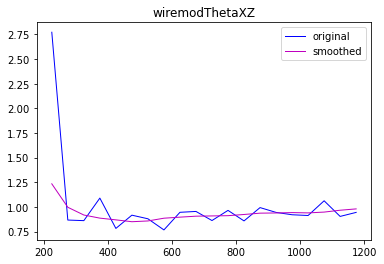

Enu_1m1p [5.46506435e-02 1.72166618e-05 6.83600845e-03 1.30686198e-02
 1.73929890e-02 2.27120711e-02 2.04373627e-02 1.32361757e-02
 1.08926558e-02 8.94018520e-03 8.46037345e-03 7.99196862e-03
 5.97819631e-03 4.07551500e-03 3.82327353e-03 3.36969219e-03
 3.74869741e-03 2.80899761e-03 1.16597289e-03 4.24400257e-04]
Enu_1m1p [3.13963053e+00 1.78974011e-02 1.95314857e-02 7.91402685e-03
 4.78316949e-02 7.10361564e-03 1.46053339e-02 5.47077660e-02
 3.05588805e-03 2.15311404e-03 1.92594957e-02 1.27385008e-03
 2.03230266e-02 5.50839193e-05 3.15428189e-03 6.40920205e-03
 7.68092197e-03 3.80360046e-03 9.38903096e-03 3.14947350e-03]


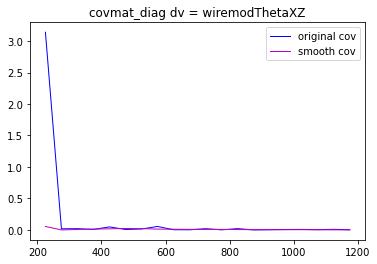

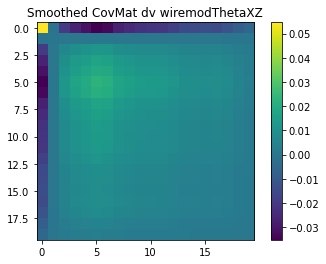

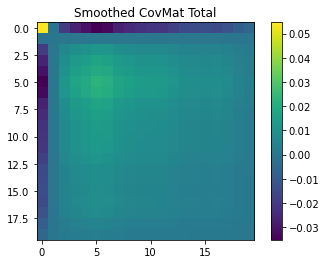

In [9]:
nbins = 20

if not os.path.exists(plotfolder):
    os.makedirs(plotfolder)
if not os.path.exists(covfolder):
    os.makedirs(covfolder)

    
#for dist in varListSel: #[9:10]
#for _,dist in varListSel.items(): # loop over all variables 
for i in range(1):
    dist = varListSel['Enu_1m1p']
#    dist = varListSel['MPID_muon']

    cov = np.zeros((nbins,nbins))
    cov_smooth = np.zeros((nbins,nbins))

    
    print(len(a_df_sys))
    for sysi in range(len(a_df_sys)): # loop over all detvars
#    for sysi in range(1):
#        sysi = 3
#        myvardf = a_df_sys[sysi].query('Enu_1m1p > 0 and Enu_1m1p_cv > 0')
        print(sysi)
        myvardf = a_df_sys[sysi].query('Enu_1m1p > 0')
        
        var_sys = myvardf.query(s_cuts)[dist.myname]
        var_cv = myvardf.query(s_cuts_cv)[dist.myname]
        print('cv = %d  and dv = %d'%(var_cv.shape[0],var_sys.shape[0]))

        pot_cv=myvardf.query("isCV==True").iloc[0]["POT"]
        pot_dv=myvardf.query("isCV==False").iloc[0]["POT"]
        print("cv POT = %f dv POT = %f"%(pot_cv,pot_dv))

        
        # get cv and detvar lists and apply weights
        var_cv_list = np.array(var_cv.astype(float).values.tolist())
        var_sys_list = np.array(var_sys.astype(float).values.tolist())
        cv_weights = np.array(myvardf.query(s_cuts_cv)['xsec_corr_weight'].astype(float).values.tolist())
        sys_weights = np.array(myvardf.query(s_cuts)['xsec_corr_weight'].astype(float).values.tolist())
        ratio = pot_cv / pot_dv

        var_cv_list = var_cv_list * cv_weights 

        var_sys_list = var_sys_list * sys_weights 
        
        
        
        CV_smooth,DV_smooth = smooth(var_cv_list,var_sys_list,dist.myrange[0],dist.myrange[1],names[sysi],nbin=nbins,ratio=ratio)


        
#        print(cv_weights)
        hCV,binedges = np.histogram(var_cv_list,bins=nbins,range=dist.myrange)#,weights= cv_weights)#cv_scale)
        h0,_ = np.histogram(var_sys_list,bins=nbins,range=dist.myrange)#,weights=sys_weights)#cv_scale)
        bincenters = np.diff(binedges)/2 + binedges[:-1] 
        h0 = h0 *ratio
        
#        hCV_smooth,binedges = np.histogram(CV_smooth,bins=nbins,range=dist.myrange)#,weights= cv_weights)#cv_scale)
#        hDV_smooth,_ = np.histogram(DV_smooth,bins=nbins,range=dist.myrange)#,weights=sys_weights)#cv_scale)
#        bincenters = np.diff(binedges)/2 + binedges[:-1] 

        
        
#        print(h0)
#        print(hCV)
#        print(bincenters)
        # polyfit
        #polyterms = 4
        #polyCV = np.polyfit(bincenters, hCV, polyterms)
        #fCV = np.poly1d(polyCV)    
        #poly0 = np.polyfit(bincenters, h0, polyterms)
        #f0 = np.poly1d(poly0)    
        #hCV = fCV(bincenters)
        #h0 = f0(bincenters)    
                
        #for i in range(nbins):
        #    for j in range(nbins):
        #        if hCV[i] > 0 and hCV[j] > 0:
        #            cov[i][j] += (h0[i]-hCV[i])*(h0[j]-hCV[j])/(hCV[i]*hCV[j])
        #        elif h0[i] > 0 and h0[j] > 0:
        #            cov[i][j] += (h0[i]-hCV[i])*(h0[j]-hCV[j])/(h0[i]*h0[j])
        cov_tmp = np.zeros((nbins,nbins))
        cov_smooth_tmp = np.zeros((nbins,nbins))            
        for i in range(nbins):
            for j in range(nbins):
                if (hCV[i]*hCV[j])<1e-8:
                    cov_tmp[i][j]=0
                else:
    #               print('%d,%d'%(h0[i],hCV[j]))
                    cov_tmp[i][j] += (h0[i]-hCV[i])*(h0[j]-hCV[j])/(hCV[i]*hCV[j])
    #               print('result is: %d*%d/%d'%(h0[i]-hCV[i],h0[j]-hCV[j],hCV[i]*hCV[j]))
    #    print(dist.myname,cov.diagonal())
        
        for i in range(nbins):
            for j in range(nbins):
                if (CV_smooth[i]*CV_smooth[j])<1e-8:
                    cov_smooth_tmp[i][j]=0
                else:
    #               print('%d,%d'%(h0[i],hCV[j]))
                    cov_smooth_tmp[i][j] += (DV_smooth[i]-CV_smooth[i])*(DV_smooth[j]-CV_smooth[j])/(CV_smooth[i]*CV_smooth[j])
    #               print('result is: %d*%d/%d'%(h0[i]-hCV[i],h0[j]-hCV[j],hCV[i]*hCV[j]))
        print(dist.myname,cov_smooth_tmp.diagonal())
        print(dist.myname,cov_tmp.diagonal())
        
        offset = (dist.myrange[1] - dist.myrange[0] )/(2*nbins)
        x= np.linspace(dist.myrange[0]+offset,dist.myrange[1]-offset,nbins)
        
        plt.plot(x,cov_tmp.diagonal(),linewidth=1, linestyle="-", c="b",label='original cov')
        plt.plot(x,cov_smooth_tmp.diagonal(),linewidth=1, linestyle="-", c="m",label='smooth cov')
        plt.legend()
        plt.title('covmat_diag dv = %s'%names[sysi])
        plt.savefig(plotfolder+'/detsys_%s_%s_%s_cov_diag.png'%(dist.myname, run,names[sysi]),dpi=120,bbox_inches='tight')
        
        plt.show()
        
        plt.imshow(cov_smooth_tmp, interpolation='none')
        plt.colorbar(orientation='vertical')
        plt.title('Smoothed CovMat dv %s'%names[sysi])

        plt.savefig(plotfolder+'/detsys_%s_%s_%s_cov.png'%(dist.myname, run,names[sysi]),dpi=120,bbox_inches='tight')
        plt.show()

        cov = cov+ cov_tmp
        cov_smooth = cov_smooth_tmp
    plt.imshow(cov_smooth, interpolation='none')
    plt.colorbar(orientation='vertical')
    plt.title('Smoothed CovMat Total')

    plt.savefig(plotfolder+'/detsys_%s_%s_cov.png'%(dist.myname, run),dpi=120,bbox_inches='tight')

    plt.show()
    np.savetxt(covfolder+'/detsys_%s_%s_cov.csv'%(dist.myname, run),cov_smooth, delimiter=',')
    

# Run 1

In [14]:
run = 'run1'
f_scaleslist = []
s_detsyslist = []
names = ['wiremodX','wiremodYZ','recomb','LYdown','LYRayleigh','SCE','wiremodThetaYZ','wiremodThetaXZ']

for name in names:
    s_detsyslist.append(name)

#df_cv = pd.read_parquet('../../data/pickles/detsys_CV_run3_nodupesMay1.parquet')
#scaleCV = 9.65858292241e+19 

a_df_sys = []

i=0
for sys in s_detsyslist:
#    print('111')
    df_sys = pd.read_parquet('%s/pickles/%s_%s_%s.parquet'%(datafolder,sys,run,tag))
    print(df_sys.shape[0])
    i+=1
    a_df_sys.append(df_sys)
    print("total %d, cv = %d dv = %d"%(df_sys.shape[0],df_sys.query("isCV==True").shape[0],df_sys.query("isCV==False").shape[0]))
#    print(df_sys.shape[0])

#df_numu_run3_presel = pd.read_parquet('../../data/pickles/numu_run1_nodupesMay1.parquet')
#print((list(a_df_sys[7])))


124884
total 124884, cv = 106578 dv = 18306
125115
total 125115, cv = 106578 dv = 18537
19956
total 19956, cv = 10017 dv = 9939
19501
total 19501, cv = 10017 dv = 9484
21024
total 21024, cv = 10017 dv = 11007
20369
total 20369, cv = 10017 dv = 10352
124406
total 124406, cv = 106578 dv = 17828
124251
total 124251, cv = 106578 dv = 17673


8
0
$$$$$$$$$$$$$$$$$$$$
[  2.000001   4.000001  29.000001  42.000001 102.000001  84.000001
 134.000001 199.000001 256.000001 343.000001 416.000001 355.000001
 375.000001 303.000001 279.000001 287.000001 199.000001 156.000001
 155.000001 116.000001]
!!!!!!!!!!!!!!!!!!!!
cv[0] =  400.276123    cv[1] = 1264.675878  rat = 0.240413
bwid = 138.429884
!!!!!!!!!!!!!!!!!!!!
[  3.43265208   4.80571251  25.40161899  48.74364633  74.83179453
  77.5779154  122.20237943 166.82684346 243.03169743 306.87900751
 366.60713629 356.30918305 340.51898809 308.93859815 280.7908593
 255.38924131 193.60152188 159.27501109 131.81380245 105.03912403]
!!!!!!!!!!!!!!!!!!!!


<ipython-input-6-2c3e09da2077>:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.5*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-6-2c3e09da2077>:121: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-6-2c3e09da2077>:129: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


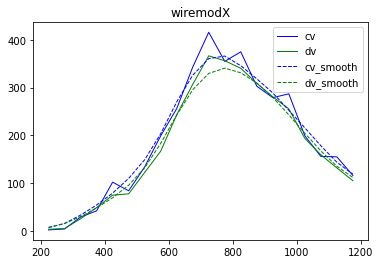

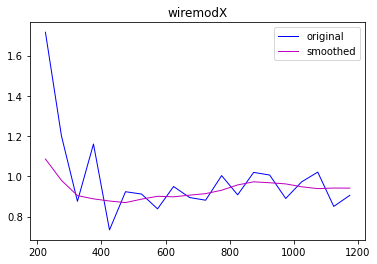

Enu_1m1p [0.00686833 0.00040662 0.01015375 0.01411173 0.01715017 0.01957113
 0.01452454 0.01094173 0.01154135 0.00966505 0.00809574 0.00512863
 0.00190488 0.00076394 0.00105169 0.00146769 0.00284933 0.00396158
 0.00360472 0.00363812]
Enu_1m1p [5.13122279e-01 4.05731900e-02 1.53963771e-02 2.57804718e-02
 7.09449676e-02 5.84512238e-03 7.75138531e-03 2.61385335e-02
 2.56617580e-03 1.10899895e-02 1.40974892e-02 1.36001400e-05
 8.45468623e-03 3.84133758e-04 4.12015963e-05 1.21312645e-02
 7.35930324e-04 4.40733526e-04 2.23766828e-02 8.92842033e-03]


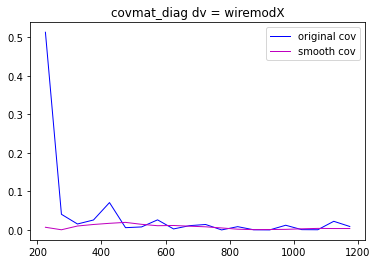

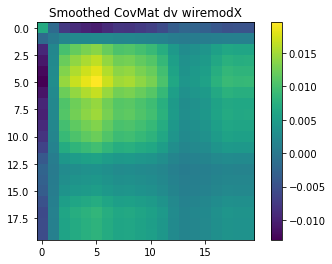

1
$$$$$$$$$$$$$$$$$$$$
[  2.000001   4.000001  29.000001  42.000001 102.000001  84.000001
 134.000001 199.000001 256.000001 343.000001 416.000001 355.000001
 375.000001 303.000001 279.000001 287.000001 199.000001 156.000001
 155.000001 116.000001]
!!!!!!!!!!!!!!!!!!!!
cv[0] =  400.276123    cv[1] = 1264.675878  rat = 0.240413
bwid = 138.429884
!!!!!!!!!!!!!!!!!!!!
[  6.85578571   6.85578571  23.99524749  45.24818009  73.35689741
  73.35689741 112.43487026 169.33788337 245.43709366 333.19113796
 375.0114247  348.9594428  342.10365809 292.74200817 277.6592818
 264.63329085 189.21965903 157.68304936 139.17243064 112.43487026]
!!!!!!!!!!!!!!!!!!!!


<ipython-input-6-2c3e09da2077>:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.5*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-6-2c3e09da2077>:121: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-6-2c3e09da2077>:129: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


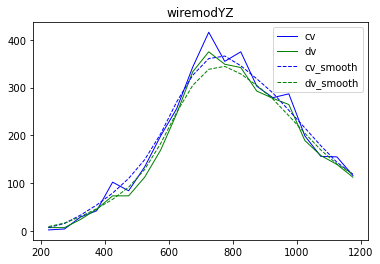

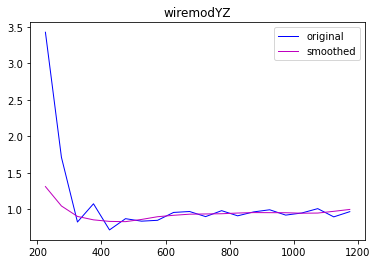

Enu_1m1p [7.46622582e-02 2.13577671e-03 1.02030123e-02 2.37968909e-02
 3.22310425e-02 3.37303042e-02 2.18392578e-02 1.11205365e-02
 7.04806300e-03 4.54777804e-03 4.13622411e-03 3.71155674e-03
 2.57964155e-03 1.95679219e-03 2.05564911e-03 2.13951975e-03
 2.85404094e-03 2.60995324e-03 6.95029076e-04 6.00290634e-08]
Enu_1m1p [5.89466129e+00 5.09719145e-01 2.97830650e-02 5.98110398e-03
 7.88569188e-02 1.60538058e-02 2.58996917e-02 2.22176516e-02
 1.70249956e-03 8.17803756e-04 9.70820652e-03 2.89532580e-04
 7.69542668e-03 1.14614490e-03 2.30923031e-05 6.07351944e-03
 2.41547156e-03 1.16397591e-04 1.04271377e-02 9.44571728e-04]


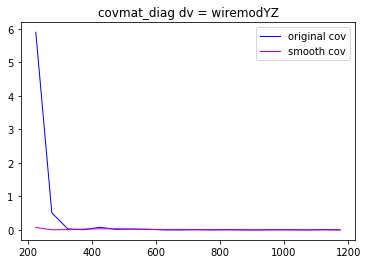

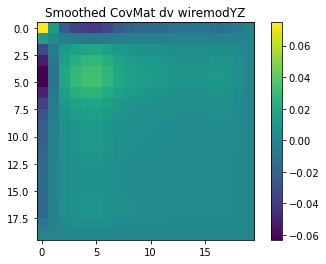

2
$$$$$$$$$$$$$$$$$$$$
[  4.000001  18.000001  68.000001  92.000001 131.000001 153.000001
 148.000001 179.000001 209.000001 204.000001 213.000001 209.000001
 201.000001 165.000001 173.000001 119.000001 123.000001  89.000001
  79.000001  60.000001]
!!!!!!!!!!!!!!!!!!!!
cv[0] =  903.975952    cv[1] = 683.390130  rat = 0.569482
bwid = 146.043588
!!!!!!!!!!!!!!!!!!!!
[  3.88447987  12.62455733  64.09390237 110.70764882 119.44772628
 133.04340233 140.81236007 165.09035302 212.67521919 197.1373037
 203.93514173 178.68602907 185.48386709 158.29251499 167.03259245
 119.44772628 128.18780374  84.48741644  73.80509955  60.2094235 ]
!!!!!!!!!!!!!!!!!!!!


<ipython-input-6-2c3e09da2077>:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.5*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-6-2c3e09da2077>:121: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-6-2c3e09da2077>:129: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


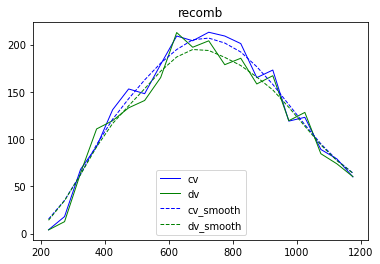

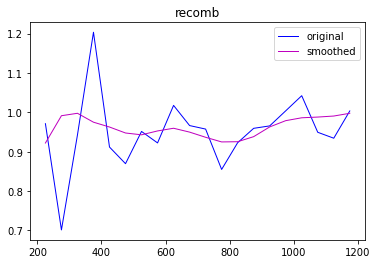

Enu_1m1p [6.59311772e-03 7.52415313e-05 6.04972411e-06 6.45011541e-04
 1.44783876e-03 2.91063321e-03 3.46351567e-03 2.34708726e-03
 1.70639887e-03 2.65955608e-03 4.29042519e-03 6.11275623e-03
 6.02246037e-03 4.06935595e-03 1.42808186e-03 4.58772994e-04
 1.95095057e-04 1.46898377e-04 8.99096878e-05 6.07248083e-06]
Enu_1m1p [8.34070702e-04 8.91833168e-02 3.29965538e-03 4.13487816e-02
 7.77664770e-03 1.70133637e-02 2.35857296e-03 6.03846032e-03
 3.09224348e-04 1.13169488e-03 1.81118547e-03 2.10374509e-02
 5.95902110e-03 1.65253879e-03 1.18981472e-03 1.41556338e-05
 1.77892110e-03 2.57081421e-03 4.32414694e-03 1.21827178e-05]


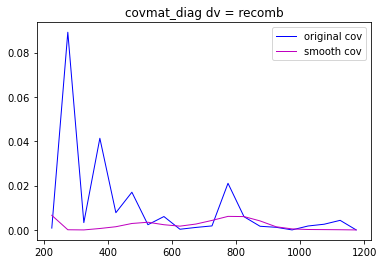

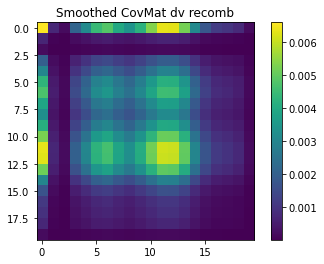

3
$$$$$$$$$$$$$$$$$$$$
[  4.000001  18.000001  68.000001  92.000001 131.000001 153.000001
 148.000001 179.000001 209.000001 204.000001 213.000001 209.000001
 201.000001 165.000001 173.000001 119.000001 123.000001  89.000001
  79.000001  60.000001]
!!!!!!!!!!!!!!!!!!!!
cv[0] =  903.975952    cv[1] = 683.390130  rat = 0.569482
bwid = 146.043588
!!!!!!!!!!!!!!!!!!!!
[  3.07525023  17.42641329  72.7808994  100.45814245 129.16046858
 150.68721317 138.38621626 162.98821008 226.5433608  193.74070236
 217.31761311 194.76578544 199.89120082 167.08854239 168.11362546
 115.83438859 118.90963782  78.93139785  75.85614862  65.60531786]
!!!!!!!!!!!!!!!!!!!!


<ipython-input-6-2c3e09da2077>:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.5*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-6-2c3e09da2077>:121: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-6-2c3e09da2077>:129: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


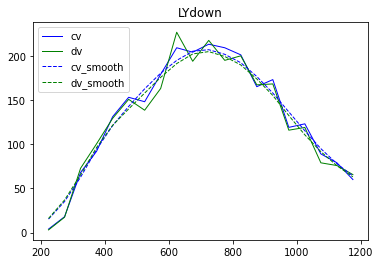

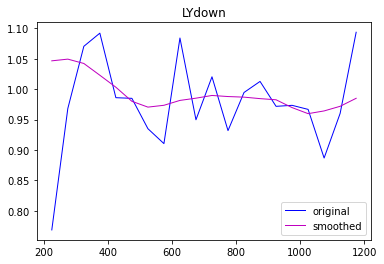

Enu_1m1p [2.06409298e-03 2.31379101e-03 1.70470117e-03 5.08348215e-04
 9.74326657e-06 4.07186163e-04 8.98492898e-04 7.22632856e-04
 3.49477455e-04 2.23558708e-04 1.08978325e-04 1.49838095e-04
 1.75324919e-04 2.46850532e-04 3.11501247e-04 9.47175590e-04
 1.68956499e-03 1.32807148e-03 8.17400328e-04 2.29593654e-04]
Enu_1m1p [5.34477494e-02 1.01544092e-03 4.94312056e-03 8.45228695e-03
 1.97184286e-04 2.28501326e-04 4.21954241e-03 8.00154328e-03
 7.04584311e-03 2.52915245e-03 4.10892335e-04 4.63846736e-03
 3.04308765e-05 1.60220574e-04 7.97776935e-04 7.07654964e-04
 1.10589404e-03 1.27984812e-02 1.58368976e-03 8.72766032e-03]


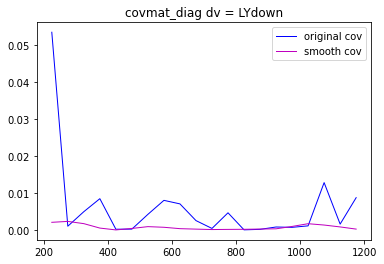

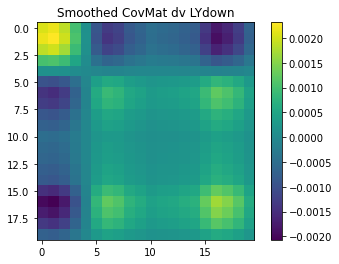

4
$$$$$$$$$$$$$$$$$$$$
[  4.000001  18.000001  68.000001  92.000001 131.000001 153.000001
 148.000001 179.000001 209.000001 204.000001 213.000001 209.000001
 201.000001 165.000001 173.000001 119.000001 123.000001  89.000001
  79.000001  60.000001]
!!!!!!!!!!!!!!!!!!!!
cv[0] =  903.975952    cv[1] = 683.390130  rat = 0.569482
bwid = 146.043588
!!!!!!!!!!!!!!!!!!!!
[  2.71118484  20.78574377  72.29823673  92.18025156 127.42564148
 147.3076563  150.92256809 154.53747988 218.70216409 188.87914185
 212.37606846 193.39778158 195.20523748 168.09339908 169.90085497
 114.77345023 131.04055327  80.43178825  71.39450879  61.45350137]
!!!!!!!!!!!!!!!!!!!!


<ipython-input-6-2c3e09da2077>:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.5*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-6-2c3e09da2077>:121: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-6-2c3e09da2077>:129: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


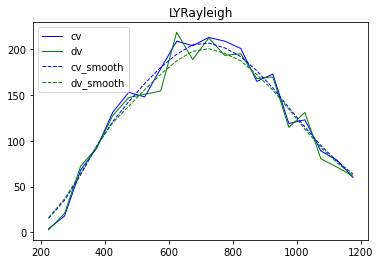

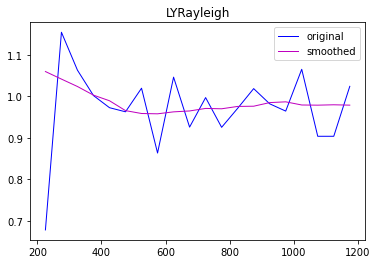

Enu_1m1p [3.39092324e-03 1.67153015e-03 5.54984435e-04 8.69916129e-06
 1.12432145e-04 1.22343627e-03 1.77925039e-03 1.84669029e-03
 1.44829050e-03 1.28088640e-03 8.70260002e-04 9.22719138e-04
 6.02396598e-04 5.75705266e-04 2.28875594e-04 1.75067292e-04
 4.40648866e-04 4.58079160e-04 4.19495007e-04 4.56423417e-04]
Enu_1m1p [1.03815443e-01 2.39517370e-02 3.99542180e-03 3.83864178e-06
 7.44481440e-04 1.38420215e-03 3.89946969e-04 1.86765375e-02
 2.15498658e-03 5.49404992e-03 8.58056843e-06 5.57288640e-03
 8.31149830e-04 3.51482522e-04 3.20916372e-04 1.26147387e-03
 4.27328182e-03 9.26830826e-03 9.26830826e-03 5.86850926e-04]


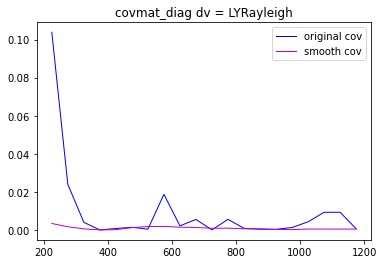

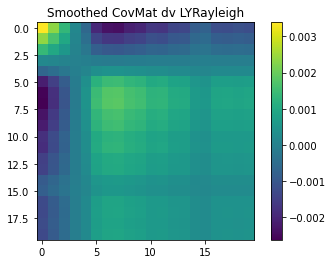

5
$$$$$$$$$$$$$$$$$$$$
[  4.000001  18.000001  68.000001  92.000001 131.000001 153.000001
 148.000001 179.000001 209.000001 204.000001 213.000001 209.000001
 201.000001 165.000001 173.000001 119.000001 123.000001  89.000001
  79.000001  60.000001]
!!!!!!!!!!!!!!!!!!!!
cv[0] =  903.975952    cv[1] = 683.390130  rat = 0.569482
bwid = 146.043588
!!!!!!!!!!!!!!!!!!!!
[  1.95938631  15.67508346  75.43633534 119.52250477 139.11635784
 146.95389907 144.01482111 195.93853176 209.65422892 213.57299953
 216.51207749 222.39023342 201.81668769 179.28375665 152.832055
 136.17727988 120.50219742  92.09111046  67.59879411  61.72063819]
!!!!!!!!!!!!!!!!!!!!


<ipython-input-6-2c3e09da2077>:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.5*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-6-2c3e09da2077>:121: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-6-2c3e09da2077>:129: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


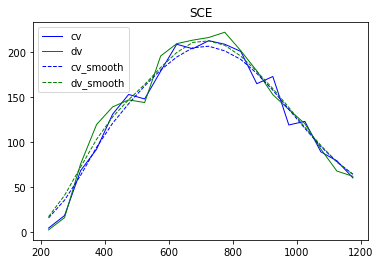

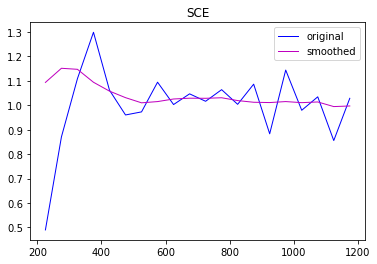

Enu_1m1p [8.03527512e-03 1.99603744e-02 1.89357409e-02 8.14158230e-03
 3.18467608e-03 9.53216621e-04 1.02951778e-04 2.29520851e-04
 6.52076349e-04 8.24488639e-04 8.01766083e-04 9.27836039e-04
 3.68868657e-04 1.54438178e-04 1.25321078e-04 2.30993601e-04
 1.17759328e-04 1.86209766e-04 2.70297449e-05 7.40055095e-06]
Enu_1m1p [2.60256770e-01 1.66828443e-02 1.19591411e-02 8.94952993e-02
 3.83866024e-03 1.56159377e-03 7.25057466e-04 8.95458395e-03
 9.79863484e-06 2.20209297e-03 2.71874657e-04 4.10472114e-03
 1.65089266e-05 7.49405603e-03 1.35903654e-02 2.08360222e-02
 4.12388309e-04 1.20628174e-03 2.08279953e-02 8.22386762e-04]


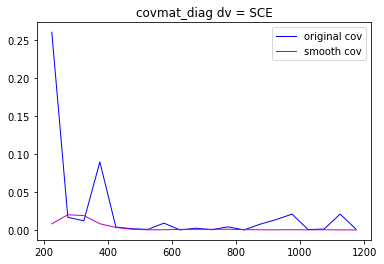

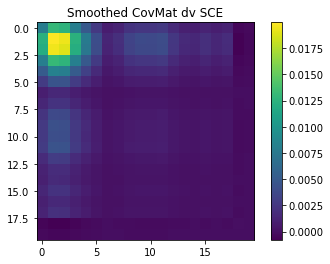

6
$$$$$$$$$$$$$$$$$$$$
[  2.000001   4.000001  29.000001  42.000001 102.000001  84.000001
 134.000001 199.000001 256.000001 343.000001 416.000001 355.000001
 375.000001 303.000001 279.000001 287.000001 199.000001 156.000001
 155.000001 116.000001]
!!!!!!!!!!!!!!!!!!!!
cv[0] =  400.276123    cv[1] = 1264.675878  rat = 0.240413
bwid = 138.429884
!!!!!!!!!!!!!!!!!!!!
[  4.26623831   4.97727786  28.44158308  49.77276963  73.9481144
  75.3701935  109.50009199 177.75988897 238.90929044 333.47755084
 368.31848888 369.74056799 325.65611577 290.81517773 290.81517773
 256.68527924 184.15924494 153.58454421 148.60726735 110.21113154]
!!!!!!!!!!!!!!!!!!!!


<ipython-input-6-2c3e09da2077>:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.5*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-6-2c3e09da2077>:121: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-6-2c3e09da2077>:129: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


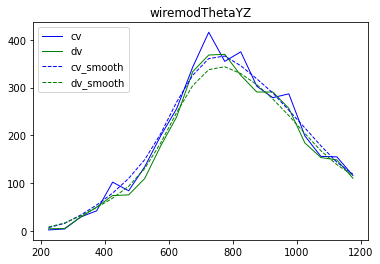

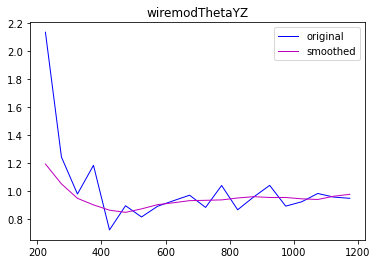

Enu_1m1p [0.03166595 0.00267369 0.0026249  0.01033628 0.02087692 0.02642276
 0.0179153  0.01000004 0.00723732 0.00474041 0.00439463 0.00399312
 0.00237224 0.00151449 0.00201587 0.0020251  0.00302822 0.00359912
 0.00127391 0.00047031]
Enu_1m1p [1.28395789e+00 5.96918792e-02 3.70785467e-04 3.42493947e-02
 7.56351732e-02 1.05546453e-02 3.34286891e-02 1.13921961e-02
 4.45697613e-03 7.70742268e-04 1.31375196e-02 1.72413660e-03
 1.73142685e-02 1.61716083e-03 1.79337882e-03 1.11568959e-02
 5.56167875e-03 2.39744884e-04 1.70102158e-03 2.49041391e-03]


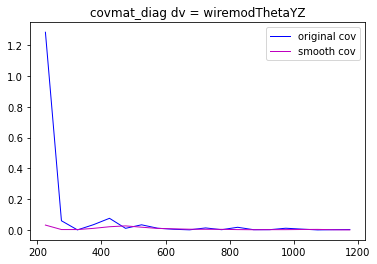

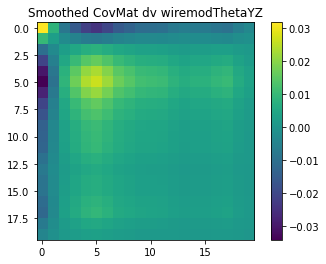

7
$$$$$$$$$$$$$$$$$$$$
[  2.000001   4.000001  29.000001  42.000001 102.000001  84.000001
 134.000001 199.000001 256.000001 343.000001 416.000001 355.000001
 375.000001 303.000001 279.000001 287.000001 199.000001 156.000001
 155.000001 116.000001]
!!!!!!!!!!!!!!!!!!!!
cv[0] =  400.276123    cv[1] = 1264.675878  rat = 0.240413
bwid = 138.429884
!!!!!!!!!!!!!!!!!!!!
[  5.54380152   3.46487632  24.94710334  45.73635529  79.69213347
  76.92023321 117.80576204 152.45451529 241.84829867 327.08423166
 358.26810958 342.32968308 321.54043114 300.75117919 263.33052568
 264.02350075 181.55946802 165.62104152 139.98096412 109.49006126]
!!!!!!!!!!!!!!!!!!!!


<ipython-input-6-2c3e09da2077>:75: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  bwid=0.5*0.9*(xmax-xmin)*((sum(cv_hist))**(-1./7))
<ipython-input-6-2c3e09da2077>:121: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatCV=(mykdeCV)*(sum(cv_hist))/sum(mykdeCV)
<ipython-input-6-2c3e09da2077>:129: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  yhatDV=(mykdeDV)*(sum(dv_hist))/sum(mykdeDV)


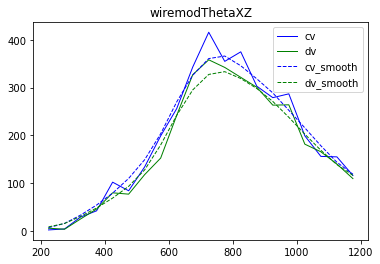

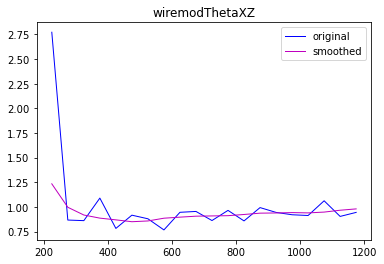

Enu_1m1p [4.42954782e-02 1.72883965e-05 7.45215369e-03 1.47554322e-02
 2.00352932e-02 2.67422718e-02 2.38464321e-02 1.49569518e-02
 1.21619755e-02 9.87377591e-03 9.31738964e-03 8.77657523e-03
 6.47915693e-03 4.35343740e-03 4.07525739e-03 3.57735420e-03
 3.99318668e-03 2.96620649e-03 1.20719416e-03 4.33327221e-04]
Enu_1m1p [3.13963053e+00 1.78974011e-02 1.95314857e-02 7.91402685e-03
 4.78316949e-02 7.10361564e-03 1.46053339e-02 5.47077660e-02
 3.05588805e-03 2.15311404e-03 1.92594957e-02 1.27385008e-03
 2.03230266e-02 5.50839193e-05 3.15428189e-03 6.40920205e-03
 7.68092197e-03 3.80360046e-03 9.38903096e-03 3.14947350e-03]


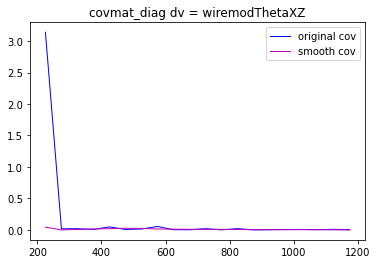

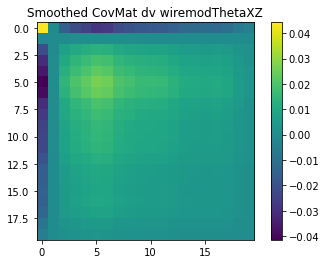

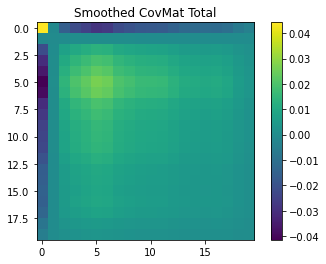

In [15]:
nbins = 20
if not os.path.exists(plotfolder):
    os.makedirs(plotfolder)
if not os.path.exists(covfolder):
    os.makedirs(covfolder)

    
#for dist in varListSel: #[9:10]
#for _,dist in varListSel.items(): # loop over all variables 
for i in range(1):
    dist = varListSel['Enu_1m1p']
#    dist = varListSel['MPID_muon']

    cov = np.zeros((nbins,nbins))
    cov_smooth = np.zeros((nbins,nbins))

    
    print(len(a_df_sys))
    for sysi in range(len(a_df_sys)): # loop over all detvars
#    for sysi in range(1):
#        sysi = 3
#        myvardf = a_df_sys[sysi].query('Enu_1m1p > 0 and Enu_1m1p_cv > 0')
        print(sysi)
        myvardf = a_df_sys[sysi].query('Enu_1m1p > 0')
        
        var_sys = myvardf.query(s_cuts)[dist.myname]
        var_cv = myvardf.query(s_cuts_cv)[dist.myname]
        # get cv and detvar lists and apply weights
        var_cv_list = np.array(var_cv.astype(float).values.tolist())
        var_sys_list = np.array(var_sys.astype(float).values.tolist())
        cv_weights = np.array(myvardf.query(s_cuts_cv)['xsec_corr_weight'].astype(float).values.tolist())
        sys_weights = np.array(myvardf.query(s_cuts)['xsec_corr_weight'].astype(float).values.tolist())

        
        pot_cv=myvardf.query("isCV==True").iloc[0]["POT"]
        pot_dv=myvardf.query("isCV==False").iloc[0]["POT"]
        ratio =pot_cv/pot_dv
        
        var_cv_list = var_cv_list * cv_weights

        var_sys_list = var_sys_list * sys_weights
        
        
        CV_smooth,DV_smooth = smooth(var_cv_list,var_sys_list,dist.myrange[0],dist.myrange[1],names[sysi],nbin=nbins,ratio=ratio)


        
#        print(cv_weights)
        hCV,binedges = np.histogram(var_cv_list,bins=nbins,range=dist.myrange)#,weights= cv_weights)#cv_scale)
        h0,_ = np.histogram(var_sys_list,bins=nbins,range=dist.myrange)#,weights=sys_weights)#cv_scale)
        bincenters = np.diff(binedges)/2 + binedges[:-1] 
        h0 = h0 *ratio
        
#        hCV_smooth,binedges = np.histogram(CV_smooth,bins=nbins,range=dist.myrange)#,weights= cv_weights)#cv_scale)
#        hDV_smooth,_ = np.histogram(DV_smooth,bins=nbins,range=dist.myrange)#,weights=sys_weights)#cv_scale)
#        bincenters = np.diff(binedges)/2 + binedges[:-1] 

        
        
#        print(h0)
#        print(hCV)
#        print(bincenters)
        # polyfit
        #polyterms = 4
        #polyCV = np.polyfit(bincenters, hCV, polyterms)
        #fCV = np.poly1d(polyCV)    
        #poly0 = np.polyfit(bincenters, h0, polyterms)
        #f0 = np.poly1d(poly0)    
        #hCV = fCV(bincenters)
        #h0 = f0(bincenters)    
                
        #for i in range(nbins):
        #    for j in range(nbins):
        #        if hCV[i] > 0 and hCV[j] > 0:
        #            cov[i][j] += (h0[i]-hCV[i])*(h0[j]-hCV[j])/(hCV[i]*hCV[j])
        #        elif h0[i] > 0 and h0[j] > 0:
        #            cov[i][j] += (h0[i]-hCV[i])*(h0[j]-hCV[j])/(h0[i]*h0[j])
        cov_tmp = np.zeros((nbins,nbins))
        cov_smooth_tmp = np.zeros((nbins,nbins))            
        for i in range(nbins):
            for j in range(nbins):
                if (hCV[i]*hCV[j])<1e-8:
                    cov_tmp[i][j]=0
                else:
    #               print('%d,%d'%(h0[i],hCV[j]))
                    cov_tmp[i][j] += (h0[i]-hCV[i])*(h0[j]-hCV[j])/(hCV[i]*hCV[j])
    #               print('result is: %d*%d/%d'%(h0[i]-hCV[i],h0[j]-hCV[j],hCV[i]*hCV[j]))
    #    print(dist.myname,cov.diagonal())
        
        for i in range(nbins):
            for j in range(nbins):
                if (CV_smooth[i]*CV_smooth[j])<1e-8:
                    cov_smooth_tmp[i][j]=0
                else:
    #               print('%d,%d'%(h0[i],hCV[j]))
                    cov_smooth_tmp[i][j] += (DV_smooth[i]-CV_smooth[i])*(DV_smooth[j]-CV_smooth[j])/(DV_smooth[i]*CV_smooth[j])
    #               print('result is: %d*%d/%d'%(h0[i]-hCV[i],h0[j]-hCV[j],hCV[i]*hCV[j]))
        print(dist.myname,cov_smooth_tmp.diagonal())
        print(dist.myname,cov_tmp.diagonal())
        
        offset = (dist.myrange[1] - dist.myrange[0] )/(2*nbins)
        x= np.linspace(dist.myrange[0]+offset,dist.myrange[1]-offset,nbins)
        
        plt.plot(x,cov_tmp.diagonal(),linewidth=1, linestyle="-", c="b",label='original cov')
        plt.plot(x,cov_smooth_tmp.diagonal(),linewidth=1, linestyle="-", c="m",label='smooth cov')
        plt.legend()
        plt.title('covmat_diag dv = %s'%names[sysi])
        plt.savefig(plotfolder+'/detsys_%s_%s_%s_cov_diag.png'%(dist.myname, run,names[sysi]),dpi=120,bbox_inches='tight')
        
        plt.show()
        
        plt.imshow(cov_smooth_tmp, interpolation='none')
        plt.colorbar(orientation='vertical')
        plt.title('Smoothed CovMat dv %s'%names[sysi])

        plt.savefig(plotfolder+'/detsys_%s_%s_%s_cov.png'%(dist.myname, run,names[sysi]),dpi=120,bbox_inches='tight')
        plt.show()

        cov = cov+ cov_tmp
        cov_smooth = cov_smooth_tmp
    plt.imshow(cov_smooth, interpolation='none')
    plt.colorbar(orientation='vertical')
    plt.title('Smoothed CovMat Total')

    plt.savefig(plotfolder+'/detsys_%s_%s_cov.png'%(dist.myname, run),dpi=120,bbox_inches='tight')

    plt.show()
    np.savetxt(covfolder+'/detsys_%s_%s_cov.csv'%(dist.myname, run),cov_smooth, delimiter=',')

In [26]:
from numpy import genfromtxt
run3 = genfromtxt('/home/itran/SLAC_Work/ML/1L1PSelection/outputs/covMatrix2021-01-21/detsys_Enu_1m1p_run3_cov.csv', delimiter=',')
run1 = genfromtxt('/home/itran/SLAC_Work/ML/1L1PSelection/outputs/covMatrix2021-01-21/detsys_Enu_1m1p_run1_cov.csv', delimiter=',')
print(np.average(run3))
print(run3.diagonal())
bla = run3-run1
print(100*bla.diagonal()/run3.diagonal())

0.0043446622312646645
[5.46506435e-02 1.72166618e-05 6.83600845e-03 1.30686198e-02
 1.73929890e-02 2.27120711e-02 2.04373627e-02 1.32361757e-02
 1.08926558e-02 8.94018520e-03 8.46037345e-03 7.99196862e-03
 5.97819631e-03 4.07551500e-03 3.82327353e-03 3.36969219e-03
 3.74869741e-03 2.80899761e-03 1.16597289e-03 4.24400257e-04]
[ 18.94792926  -0.41665849  -9.01323112 -12.90734963 -15.19177751
 -17.74475177 -16.68057365 -13.00055316 -11.65298625 -10.44263285
 -10.1297678   -9.81743863  -8.37979535  -6.81931977  -6.59078825
  -6.1626404   -6.52197937  -5.5966184   -3.53535394  -2.10343043]


In [31]:
dvar = varListSel['Xreco']
nbins = 14
cov = np.zeros((nbins,nbins))
flatsys = 0.0

for sysi in range(len(a_df_sys)):
    myvardf = a_overlap_sys[sysi].query(s_cuts)
    myvarcv = a_cv_sys[sysi].query(s_cuts_cv)
        
    var_sys = myvardf[dvar.myname]
    var_cv = myvarcv[dvar.myname+'_cv']
          
    hCV,binedges = np.histogram(var_cv,bins=nbins,range=dvar.myrange)
    h0,_ = np.histogram(var_sys,bins=nbins,range=dvar.myrange)
    bincenters = np.diff(binedges)/2 + binedges[:-1]
        
    # polyfit
    polyterms = 4
    polyCV = np.polyfit(bincenters, hCV, polyterms)
    fCV = np.poly1d(polyCV)    
    poly0 = np.polyfit(bincenters, h0, polyterms)
    f0 = np.poly1d(poly0)    
    
    hCV_fit = fCV(bincenters)
    h0_fit = f0(bincenters)
    
    #Savitsky Golay
    window_length = 7
    little_poly_t = 3
    hCV_sgfit = signal.savgol_filter(hCV, window_length, little_poly_t)
    h0_sgfit = signal.savgol_filter(h0, window_length, little_poly_t)
        
    
    fig,ax = plt.subplots(figsize=(16,11))
        
    dvarLinspace = np.linspace(dvar.myrange[0],dvar.myrange[1],40)
    #plt.plot(dvarLinspace,fCV(dvarLinspace),label='CV Fit (%f)'%chi2_cv)
    #plt.plot(dvarLinspace,f0(dvarLinspace),label='Variation Fit (%f)'%chi2_h0)
    #plt.scatter(bincenters,hCV_sgfit,label='CV SG Fit (%f)'%chi2_cv_sgfit,marker='o',s=120)
    #plt.scatter(bincenters,h0_sgfit,label='Variation SG Fit (%f)'%chi2_h0_sgfit,marker='o')
    ax.set_title(s_detsyslist[sysi],fontsize=30)
    ax.set_xlabel(dvar.mylabel,fontsize=20)
    ax.legend(fontsize=15)
    
    
    for i in range(nbins):
        for j in range(nbins):
            cov[i][j] += (h0[i]-hCV[i])*(h0[j]-hCV[j])/(hCV[i]*hCV[j])
            #cov[i][j] += (h0_fit[i]-hCV_fit[i])*(h0_fit[j]-hCV_fit[j])/(hCV_fit[i]*hCV_fit[j])
            #cov[i][j] += (h0_sgfit[i]-hCV_sgfit[i])*(h0_sgfit[j]-hCV_sgfit[j])/(hCV_sgfit[i]*hCV_sgfit[j])
    flatsys += np.power(h0.sum()-hCV.sum(),2)/float(h0.sum()*hCV.sum())
            
            
print('flat sys:',np.sqrt(flatsys),flatsys)
print(dvar.myname,cov[0][0],cov[7][7])
X, Y = np.meshgrid(binedges,binedges)

fig,ax = plt.subplots(figsize=(10,10))
crat = ax.pcolormesh(X, Y,cov.T,cmap='cool')#,vmin=-2,vmax=3)
cbar = fig.colorbar(crat)
ax.set_title('Fractional Covariance Matrix',fontsize=30)
ax.set_ylabel(dvar.mylabel,fontsize=20)
ax.set_xlabel(dvar.mylabel,fontsize=20)
#np.savetxt('/home/dcianci/Downloads/detsys_enu_sgfit_cov.csv',cov,delimiter=',')

#cov = np.zeros((nbins,nbins))
#for i in range(nbins):
#    cov[i][i] = flatsys
#np.savetxt('/home/dcianci/Downloads/detsys_enu_flat_cov.csv',cov,delimiter=',')



NameError: name 'a_overlap_sys' is not defined

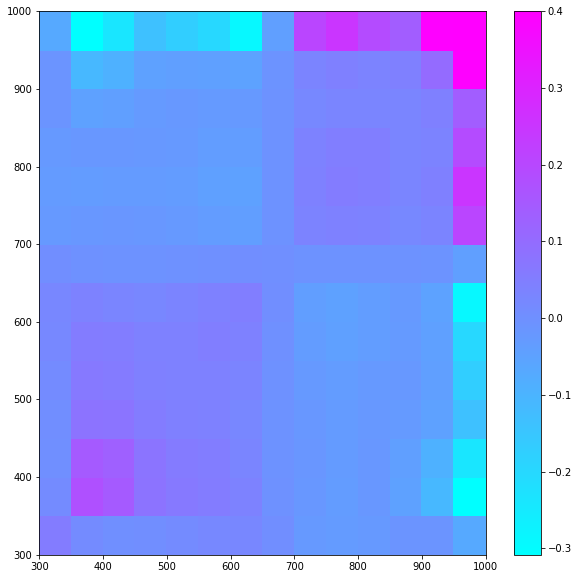

In [138]:
X, Y = np.meshgrid(binedges,binedges)

fig,ax = plt.subplots(figsize=(10,10))
crat = ax.pcolormesh(X, Y,cov,cmap='cool',vmax=.4)
cbar = fig.colorbar(crat)


In [59]:
list(df_sys)

['Proton_CosTheta_cv',
 'Lepton_CosTheta_cv',
 'Proton_CosTheta',
 'Lepton_CosTheta',
 'bkgBDT_run3_cv',
 'bkgBDT_run3',
 'run',
 'subrun',
 'event',
 'vtxid',
 'Xreco',
 'Yreco',
 'Zreco',
 'InFiducial',
 'AnyReco',
 'NTracks',
 'N5cmTracks',
 'PassSimpleCuts',
 'PassShowerReco',
 'PassSecondShower',
 'FailedBoost',
 'FailedBoost_1m1p',
 'FailedBoost_1e1p',
 'Good3DReco',
 'Eta',
 'OpenAng',
 'Thetas',
 'Phis',
 'QCorrectionFactorVertex',
 'ChargeNearTrunk',
 'LongTrackLen',
 'ShortTrackLen',
 'MaxShrFrac',
 'MinShrFrac',
 'CCQEEnergyShift_1m1p',
 'Enu_1m1p',
 'PhiT_1m1p',
 'AlphaT_1m1p',
 'PT_1m1p',
 'PTRat_1m1p',
 'BjX_1m1p',
 'BjY_1m1p',
 'Q2_1m1p',
 'Sph_1m1p',
 'PzEnu_1m1p',
 'Q0_1m1p',
 'Q3_1m1p',
 'OpenAngB_1m1p',
 'ThetasB_1m1p',
 'PhisB_1m1p',
 'PhiTB_1m1p',
 'AlphaTB_1m1p',
 'PTB_1m1p',
 'BjXB_1m1p',
 'BjYB_1m1p',
 'Q2B_1m1p',
 'SphB_1m1p',
 'CCQEEnergyShift_1e1p',
 'Enu_1e1p',
 'PhiT_1e1p',
 'AlphaT_1e1p',
 'PT_1e1p',
 'PTRat_1e1p',
 'BjX_1e1p',
 'BjY_1e1p',
 'Q2_1e1p',
 'S

wiremodX
polyfit degrees: 0 7.19169553120931
sg window_length 7 degrees: 10 7.116065343221028
wiremodYZ
polyfit degrees: 0 14.652654012044271
sg window_length 7 degrees: 10 14.726931889851889
wiremoddEdx
polyfit degrees: 0 8.301823933919271
sg window_length 1 degrees: 10 8.199064095815023
LYdown
polyfit degrees: 0 5.715118010838826
sg window_length 9 degrees: 10 5.694827159245809
SCE
polyfit degrees: 0 14.362505276997885
sg window_length 9 degrees: 10 14.273023923238119
wiremodThetaYZ
polyfit degrees: 0 6.244710286458333
sg window_length 11 degrees: 10 6.2069681485493975
wiremodThetaXZ
polyfit degrees: 0 10.961923917134603
sg window_length 3 degrees: 10 10.499676068623861
flat sys: 0.08959695735944827 0.008027614768070792


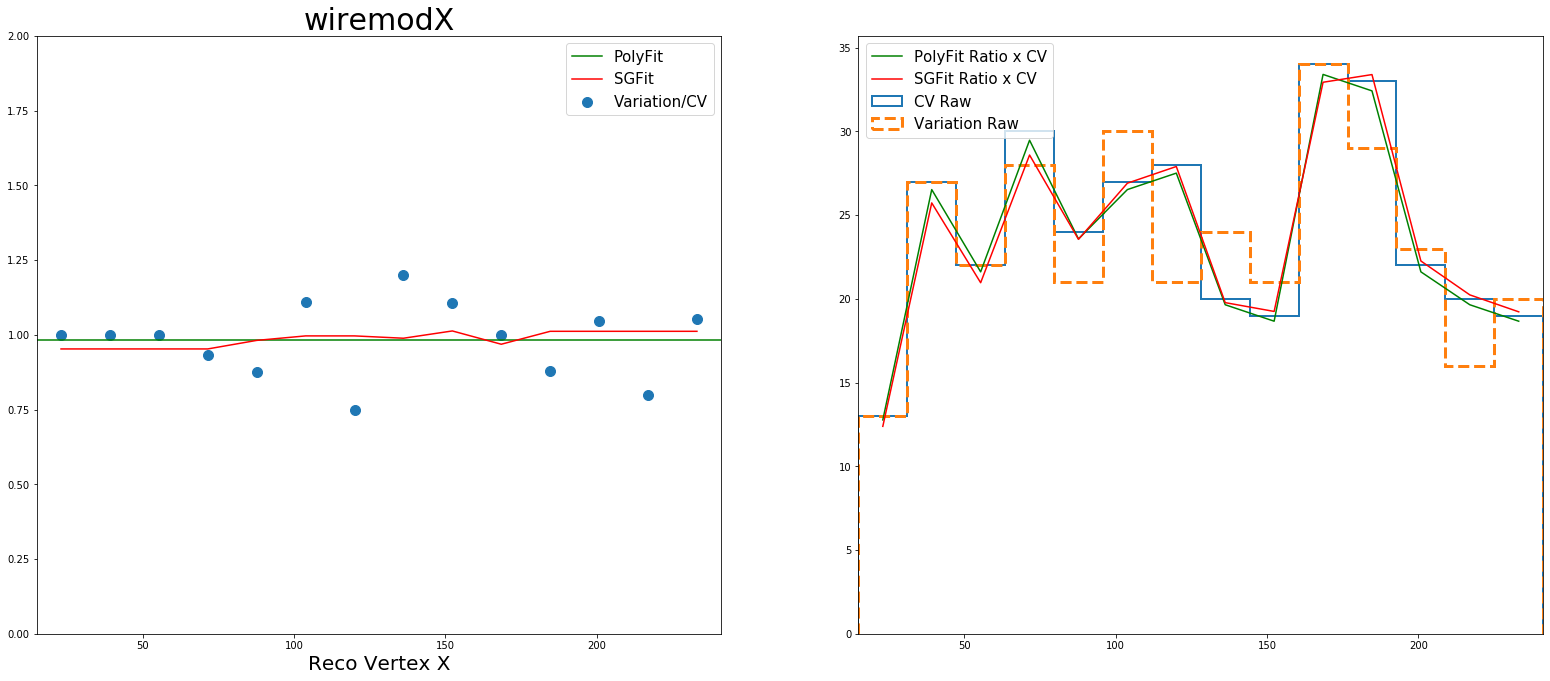

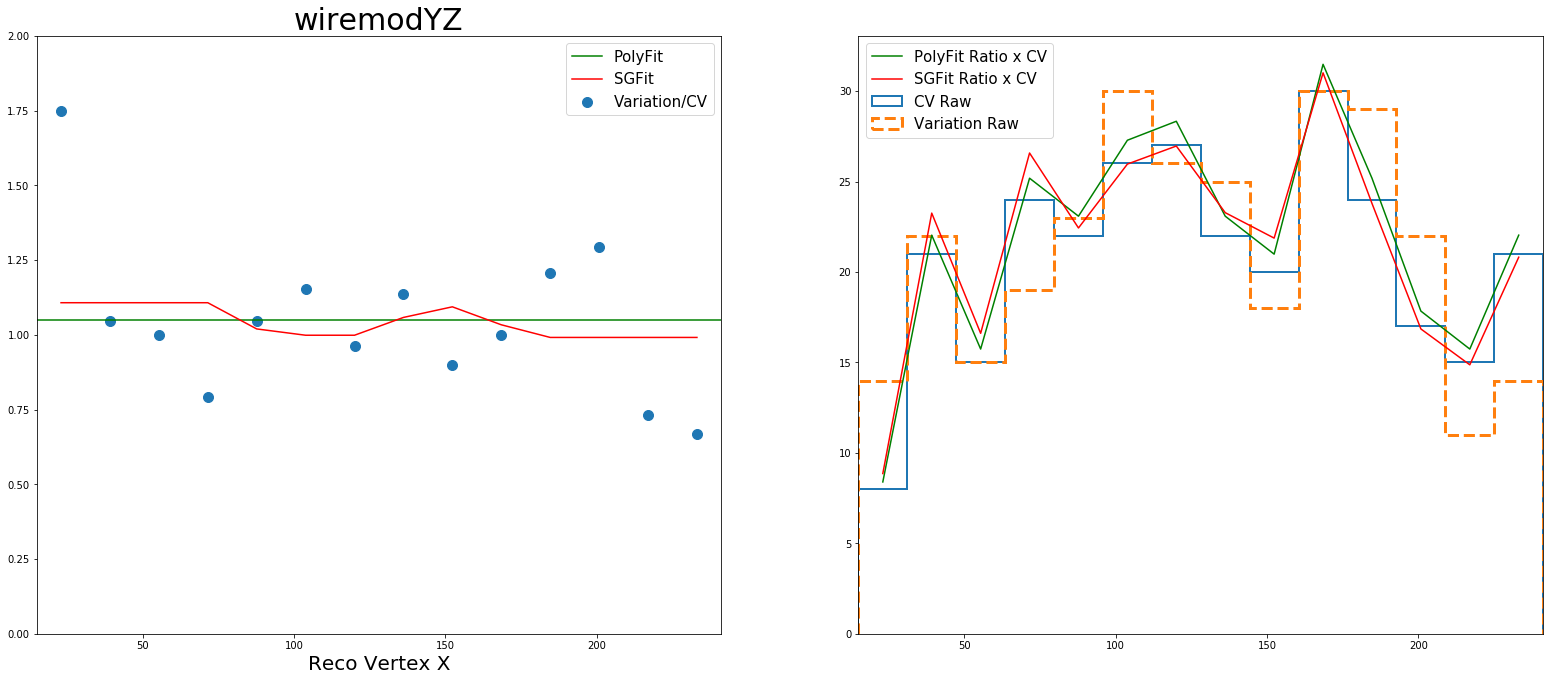

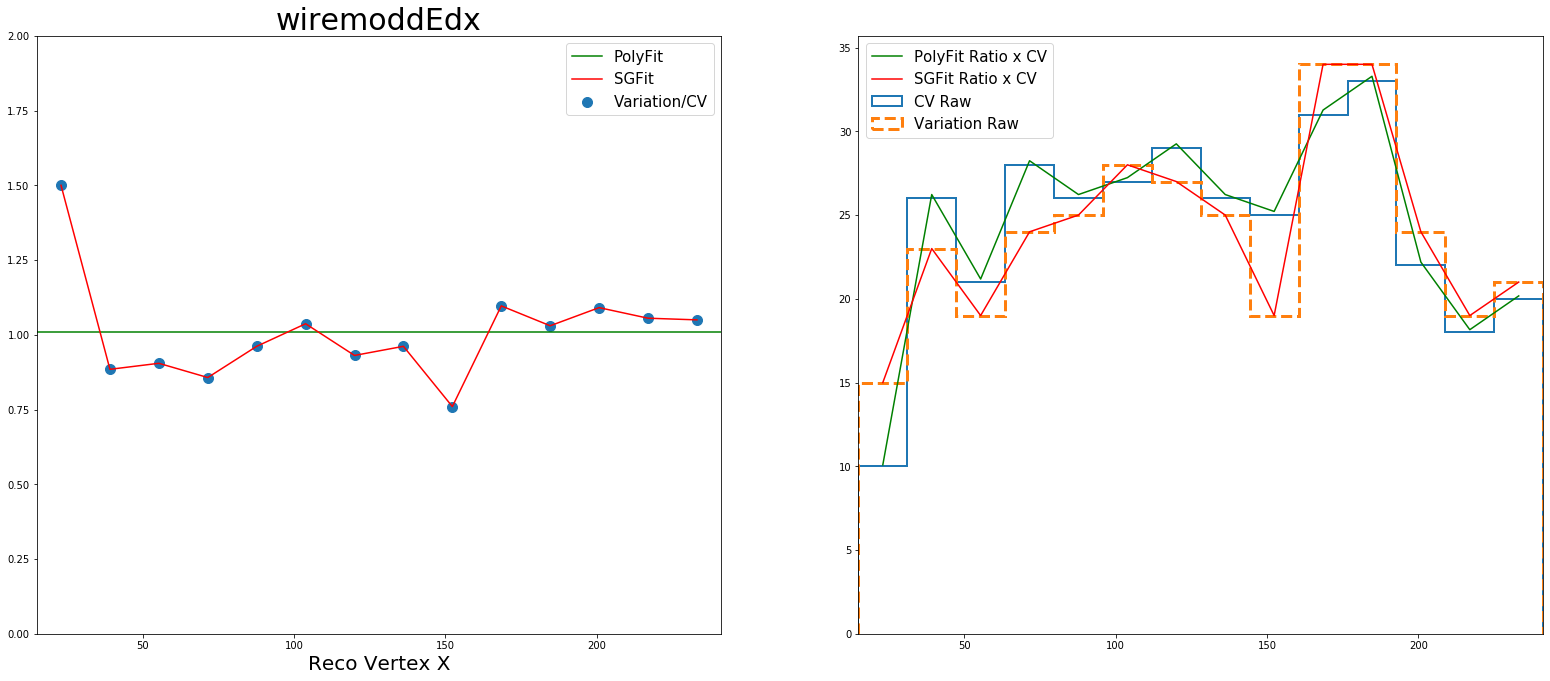

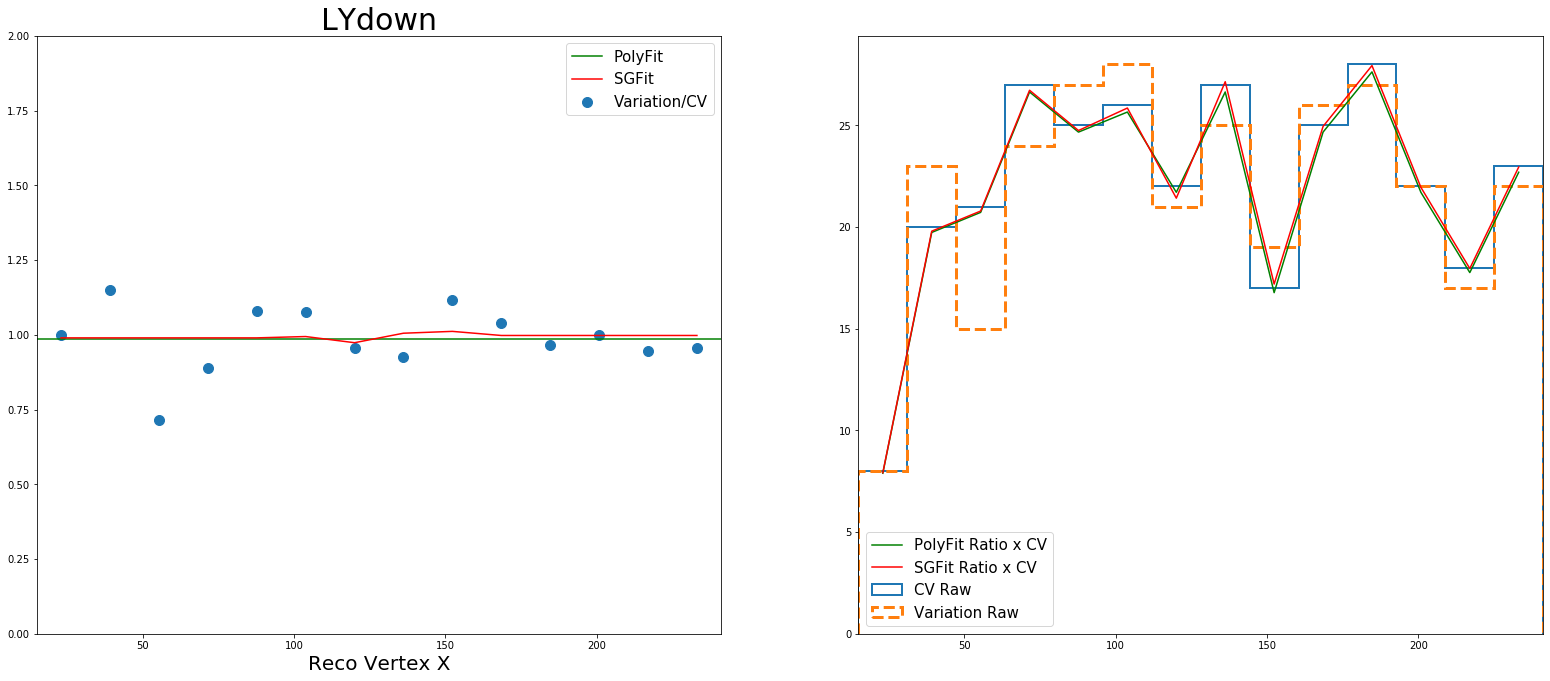

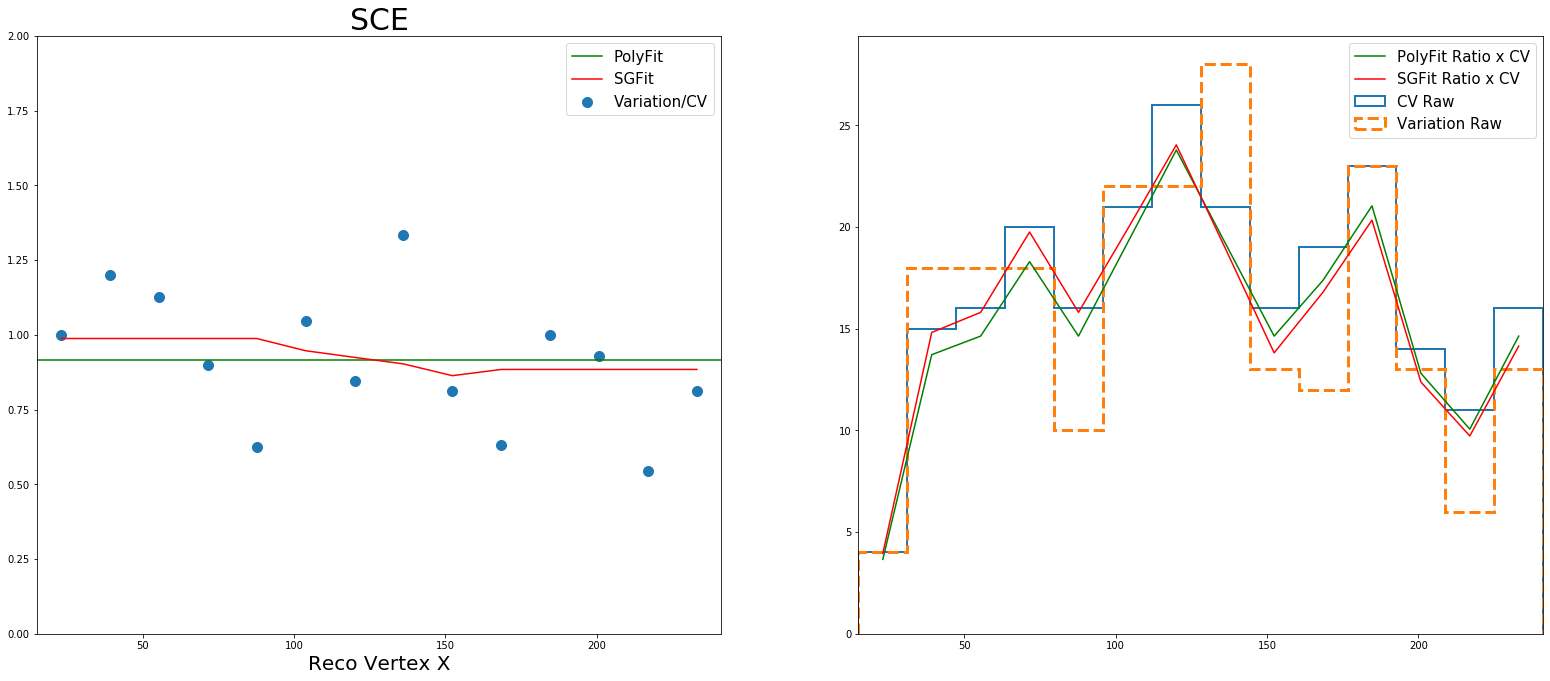

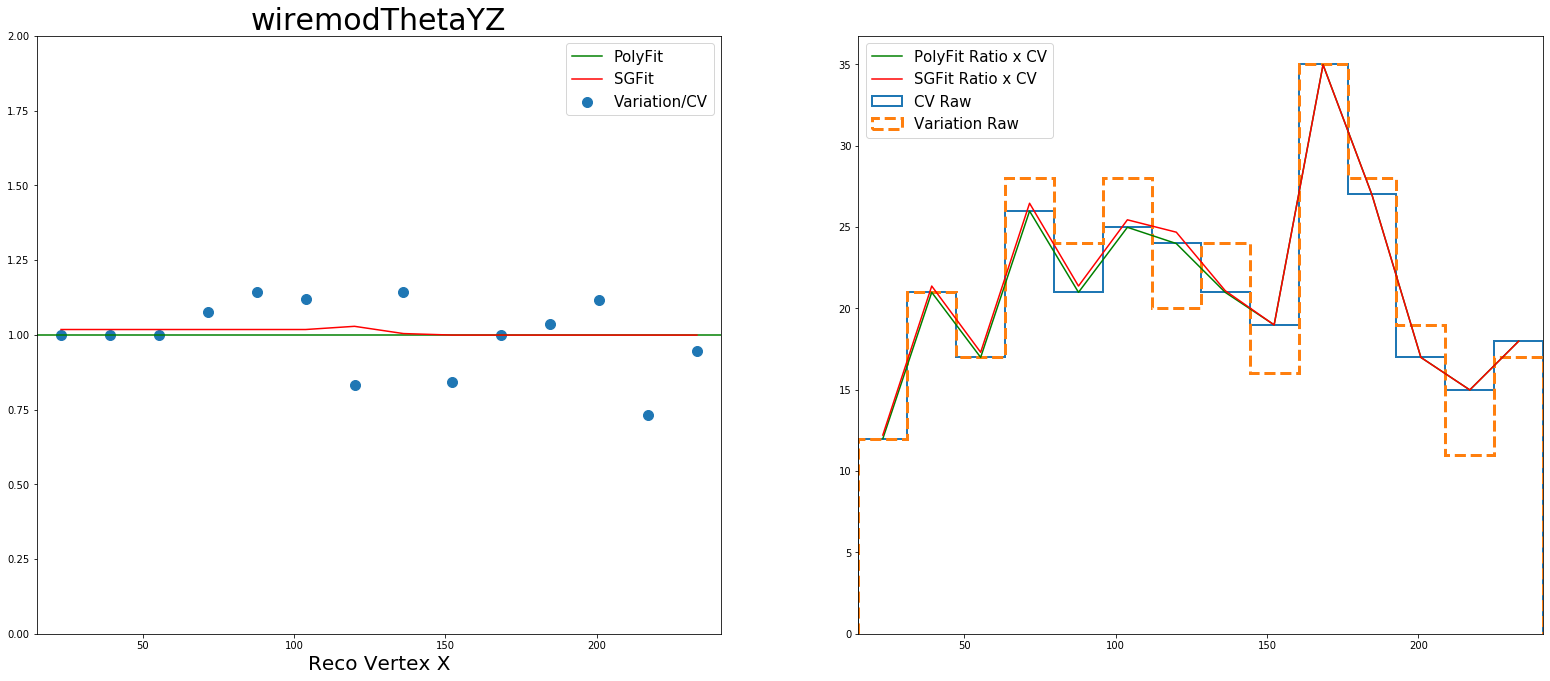

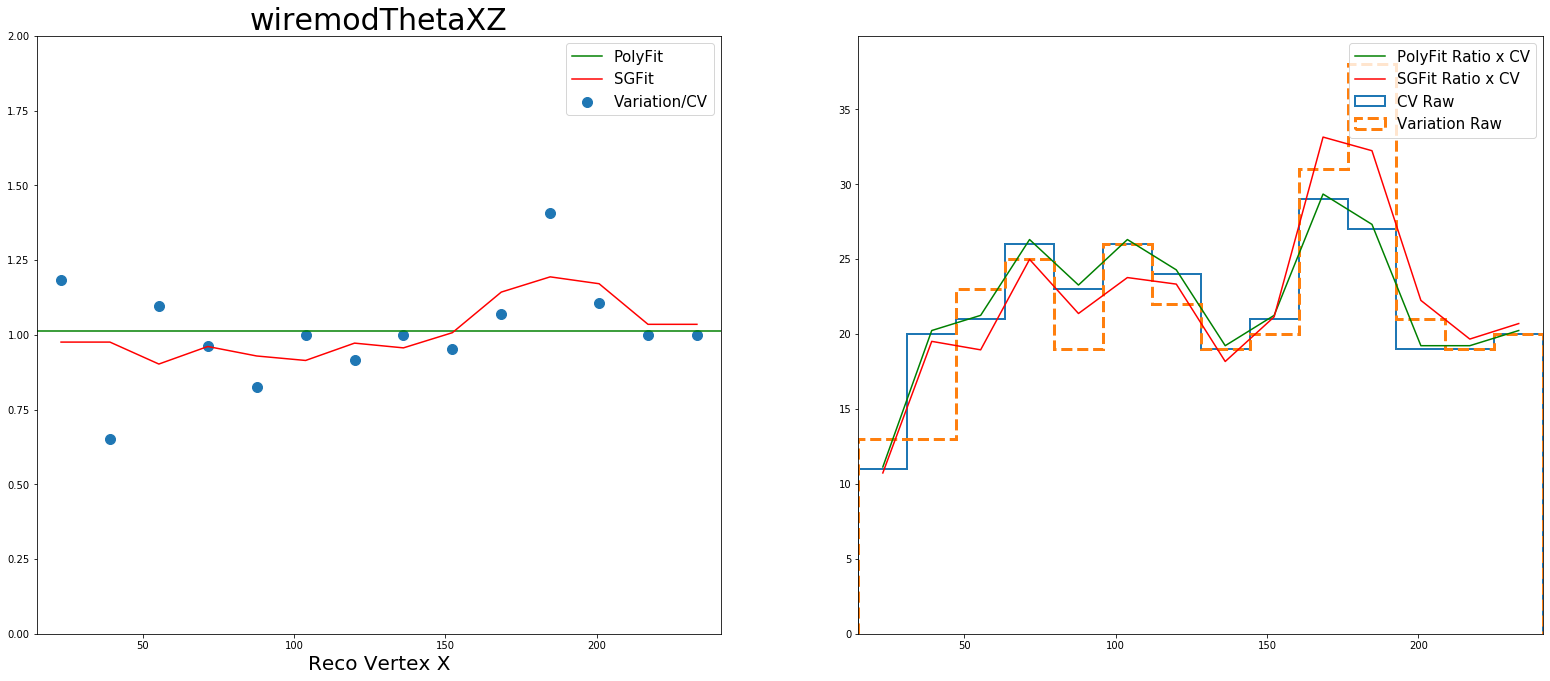

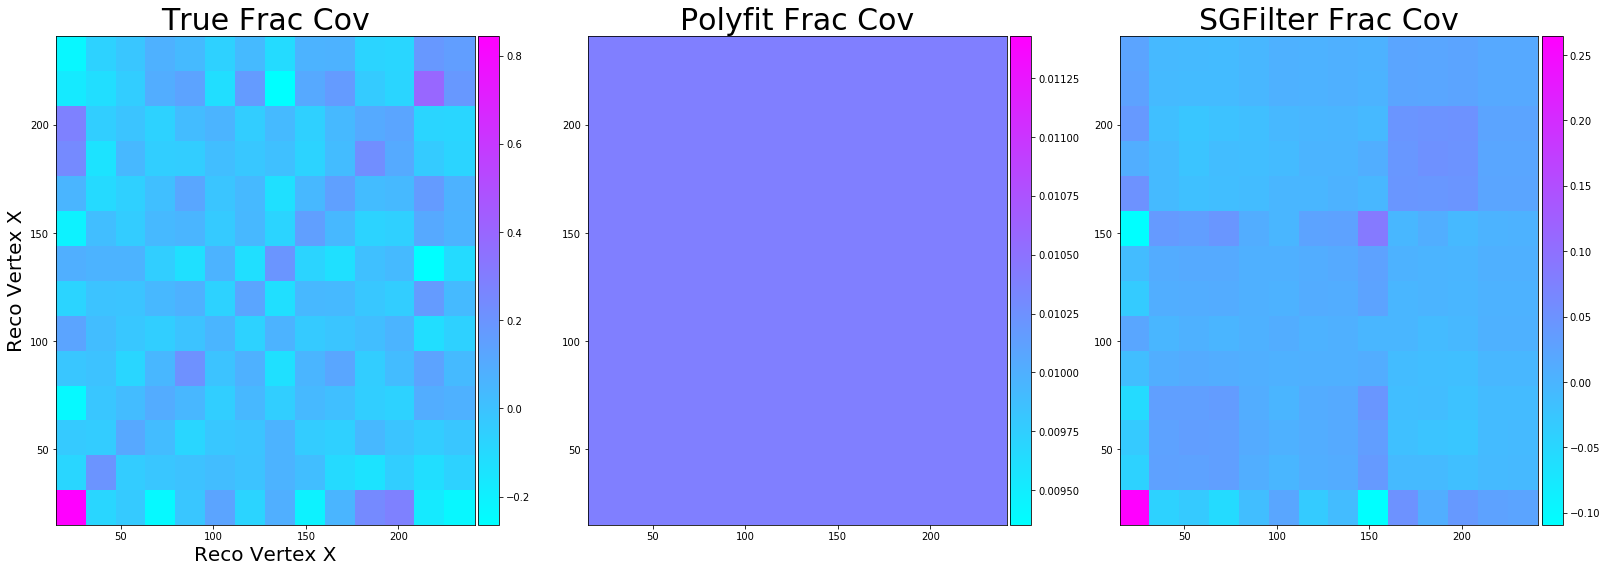

In [153]:
# The same thing with ratios

dvar = varListSel['Xreco']
nbins = 14
cov_tru = np.zeros((nbins,nbins))
cov_poly = np.zeros((nbins,nbins))
cov_sg = np.zeros((nbins,nbins))
flatsys = 0.0

for sysi in range(len(a_df_sys)):
    print(s_detsyslist[sysi])
    myvardf = a_overlap_sys[sysi].query(s_cuts)
    myvarcv = a_cv_sys[sysi].query(s_cuts_cv)
        
    var_sys = myvardf[dvar.myname]
    var_cv = myvarcv[dvar.myname+'_cv']
          
    hCV,binedges = np.histogram(var_cv,bins=nbins,range=dvar.myrange)
    h0,_ = np.histogram(var_sys,bins=nbins,range=dvar.myrange)
    bincenters = np.diff(binedges)/2 + binedges[:-1]

    truRat = np.true_divide(h0,hCV,out=np.ones_like(bincenters),where=hCV!=0)
      
    # get polyfit degs
    aics = []
    degs = []
    for deg in range(min(nbins-2,int(nbins/2))):
        params = deg + 1
        polyRat = np.polyfit(bincenters, truRat, deg)
        fRat = np.poly1d(polyRat)
    
        # now calculate chi2 for fit
        yerr_rat = np.true_divide(np.sqrt(fRat(bincenters)*hCV),hCV,out=np.zeros_like(bincenters),where=hCV!=0)
        chi2_fit = np.power(np.true_divide(fRat(bincenters)-truRat,yerr_rat),2).sum()
        aic = chi2_fit + 2*params + 2*params*(params+1)/float(nbins-params-1)
        aics.append(aic)
        degs.append(deg)
      
    polyterms = degs[np.argmin(aics)]
    print('polyfit degrees:',polyterms,aics[np.argmin(aics)])  
    polyRat = np.polyfit(bincenters, np.true_divide(h0,hCV,where=hCV!=0), polyterms)
    fRat = np.poly1d(polyRat) 
    h0_fit = fRat(bincenters)*hCV
    
    # get sg degs
    aics = []
    degs = []
    wls = []
    for window_length in range(1,nbins-1,2):
        for deg in range(window_length):   
            params = deg + 1
            sgRat = signal.savgol_filter(np.true_divide(h0,hCV,where=hCV!=0), window_length, deg)
            
            # now calculate chi2 for fit
            yerr_rat = np.true_divide(np.sqrt(sgRat*hCV),hCV,out=np.zeros_like(bincenters),where=hCV!=0)
             
            chi2_fit = np.power(np.true_divide(fRat(bincenters)-truRat,yerr_rat,out=np.zeros_like(bincenters),where=yerr_rat!=0),2).sum()
            aic = chi2_fit + 2*params + 2*params*(params+1)/float(nbins-params-1)
            aics.append(aic)
            degs.append(deg)
            wls.append(window_length)
           
    #Savitsky Golay
    window_length = wls[np.argmin(aics)]
    little_poly_t = degs[np.argmin(aics)]
    print('sg window_length',window_length,'degrees:',deg,aics[np.argmin(aics)])
    sgRat = signal.savgol_filter(np.true_divide(h0,hCV,where=hCV!=0), window_length, little_poly_t)
    h0_sgfit = sgRat*hCV
        
    fig,ax = plt.subplots(figsize=(27,11))    
    gs = gridspec.GridSpec(1, 2)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    
    dvarLinspace = np.linspace(dvar.myrange[0],dvar.myrange[1],40)
    ax0.scatter(bincenters,np.true_divide(h0,hCV,where=hCV!=0),label='Variation/CV',s=100)
    ax0.plot(dvarLinspace,fRat(dvarLinspace),label='PolyFit',color='green')
    ax0.plot(bincenters,sgRat,label='SGFit',color='red')
    
    ax0.set_title(s_detsyslist[sysi],fontsize=30)
    ax0.set_xlabel(dvar.mylabel,fontsize=20)
    ax0.legend(fontsize=15)
    
    ax1.hist(var_cv,nbins,range=dvar.myrange,histtype='step',linewidth=2,label='CV Raw')
    ax1.hist(var_sys,nbins,range=dvar.myrange,histtype='step',linewidth=3,linestyle='--',label='Variation Raw')
    ax1.plot(bincenters,h0_fit,label='PolyFit Ratio x CV',c='green')
    ax1.plot(bincenters,h0_sgfit,label='SGFit Ratio x CV',c='red')
    ax1.legend(fontsize=15)
    ax1.set_xlim(dvar.myrange)
    
    for i in range(nbins):
        for j in range(nbins):
            cov_tru[i][j] += (h0[i]-hCV[i])*(h0[j]-hCV[j])/(hCV[i]*hCV[j])
            cov_poly[i][j] += (h0_fit[i]-hCV[i])*(h0_fit[j]-hCV[j])/(hCV[i]*hCV[j])
            cov_sg[i][j] += (h0_sgfit[i]-hCV[i])*(h0_sgfit[j]-hCV[j])/(hCV[i]*hCV[j])
    flatsys += np.power(h0.sum()-hCV.sum(),2)/float(h0.sum()*hCV.sum())
    
    ax0.set_xlim(dvar.myrange)
    ax0.set_ylim(0,2)
    
fig,ax = plt.subplots(figsize=(27,9))
gs = gridspec.GridSpec(1, 3)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

X, Y = np.meshgrid(binedges,binedges)

crat_tru = ax0.pcolormesh(X, Y,cov_tru,cmap='cool')#,vmin=-2,vmax=3)
crat_poly = ax1.pcolormesh(X, Y,cov_poly,cmap='cool')#,vmin=-2,vmax=3)
crat_sg = ax2.pcolormesh(X, Y,cov_sg,cmap='cool')#,vmin=-2,vmax=3)

divider0 = make_axes_locatable(ax0)
divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)

cax0 = divider0.append_axes('right', size='5%', pad=0.05)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)

cbar = fig.colorbar(crat_tru,cax0)
cbar = fig.colorbar(crat_poly,cax1)
cbar = fig.colorbar(crat_sg,cax2)

ax0.set_title('True Frac Cov',fontsize=30)
ax1.set_title('Polyfit Frac Cov',fontsize=30)
ax2.set_title('SGFilter Frac Cov',fontsize=30)

ax0.set_ylabel(dvar.mylabel,fontsize=20)
ax0.set_xlabel(dvar.mylabel,fontsize=20)

print('flat sys:',np.sqrt(flatsys),flatsys)
np.savetxt('/home/dcianci/Downloads/detsys_%s_nom_cov.csv'%dvar.myname,cov_tru,delimiter=',')
np.savetxt('/home/dcianci/Downloads/detsys_%s_polyfit_cov.csv'%dvar.myname,cov_poly,delimiter=',')
np.savetxt('/home/dcianci/Downloads/detsys_%s_sg_cov.csv'%dvar.myname,cov_sg,delimiter=',')

cov_flat = np.zeros((nbins,nbins))
for i in range(nbins):
    cov_flat[i][i] = flatsys
np.savetxt('/home/dcianci/Downloads/detsys_%s_flat_cov.csv'%dvar.myname,cov_flat,delimiter=',')


## Let's find a good fit

testneg,testzero: [3.57341932 5.14984534 4.6486157  5.42841363 4.85532075 5.14984534
 5.2443458  4.43228117 4.3200533  5.77898761 5.69336824 4.6486157
 4.43228117 4.3200533 ] [13 27 22 30 24 27 28 20 19 34 33 22 20 19]
degree: 0 chi2: 4.858361287099476 AIC: 7.191694620432809
testneg,testzero: [3.58460323 5.16348664 4.65869297 5.43756843 4.86117103 5.1535693
 5.24561031 4.43121234 4.31692725 5.77201615 5.68375055 4.63851669
 4.42050956 4.30649029] [13 27 22 30 24 27 28 20 19 34 33 22 20 19]
degree: 1 chi2: 4.85521127016807 AIC: 9.94612036107716
testneg,testzero: [3.5606019  5.14488139 4.6538984  5.44316405 4.87367964 5.17214315
 5.2672318  4.44949474 4.33253077 5.7869404  5.6896391  4.63370125
 4.40441123 4.27729037] [13 27 22 30 24 27 28 20 19 34 33 22 20 19]
degree: 2 chi2: 4.8453018282503555 AIC: 13.245301828250357
testneg,testzero: [3.59961408 5.14921655 4.6303984  5.4024315  4.83840441 5.14579844
 5.25763767 4.45759211 4.35454975 5.82872384 5.7321843  4.6571843
 4.40065667 4.229296

/home/dcianci/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/dcianci/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/dcianci/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/dcianci/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


(0, 2)

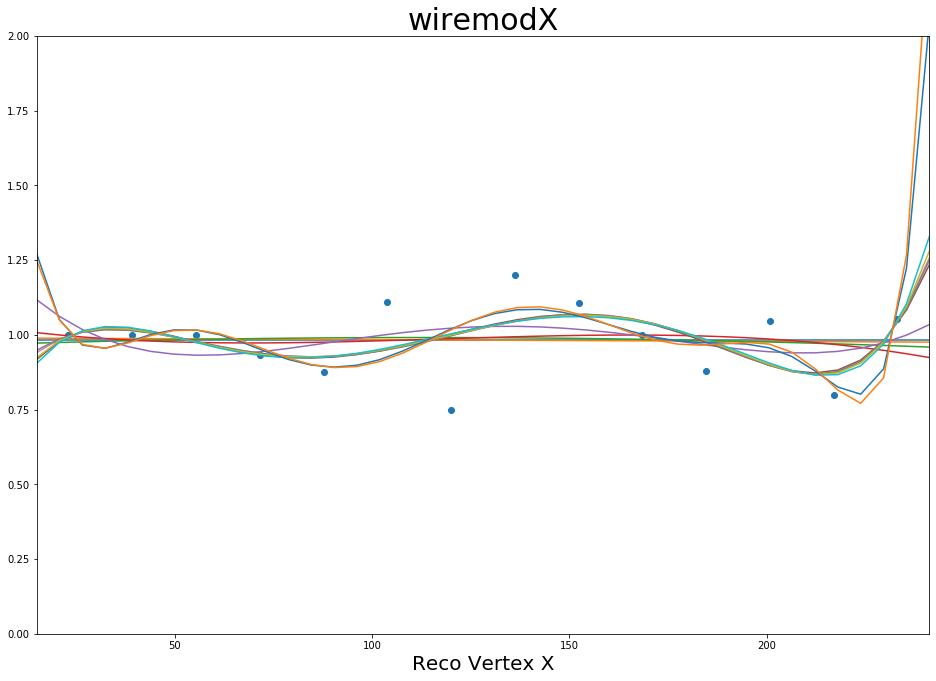

In [117]:
# The same thing with ratios

dvar = varListSel['Xreco']
nbins = 14
cov = np.zeros((nbins,nbins))
flatsys = 0.0

sysi = 0

myvardf = a_overlap_sys[sysi].query(s_cuts)
myvarcv = a_cv_sys[sysi].query(s_cuts_cv)
        
var_sys = myvardf[dvar.myname]
var_cv = myvarcv[dvar.myname+'_cv']
          
hCV,binedges = np.histogram(var_cv,bins=nbins,range=dvar.myrange)
h0,_ = np.histogram(var_sys,bins=nbins,range=dvar.myrange)
bincenters = np.diff(binedges)/2 + binedges[:-1]
truRat = np.true_divide(h0,hCV)

fig,ax = plt.subplots(figsize=(16,11))    
dvarLinspace = np.linspace(dvar.myrange[0],dvar.myrange[1],40)
plt.scatter(bincenters,np.true_divide(h0,hCV),label='Variation/CV')

# polyfit
aics = []
degs = []
for deg in range(nbins-2):
        
    params = deg + 1
    polyRat = np.polyfit(bincenters, truRat, deg)
    fRat = np.poly1d(polyRat)
    h0_fit = fRat(bincenters)*hCV
    
    # now calculate chi2 for fit
    print('testneg,testzero:',np.sqrt(h0_fit),hCV)
    yerr_rat = np.true_divide(np.sqrt(h0_fit),hCV)
    chi2_fit = np.power(np.true_divide(fRat(bincenters)-truRat,yerr_rat),2).sum()
    aic = chi2_fit + 2*params + 2*params*(params+1)/float(nbins-params-1)
    print('degree:',deg,'chi2:',chi2_fit,'AIC:',aic)
    plt.plot(dvarLinspace,fRat(dvarLinspace),label='PolyFit (%i)'%polyterms)
    aics.append(aic)
    degs.append(deg)
    

print(degs[np.argmin(aics)])

ax.set_title(s_detsyslist[sysi],fontsize=30)
ax.set_xlabel(dvar.mylabel,fontsize=20)
#ax.legend(fontsize=15)
      
ax.set_xlim(dvar.myrange)
ax.set_ylim(0,2)


window_length 1 degree: 0 chi2: 9.263592560412054 AIC: 11.596925893745388
window_length 3 degree: 0 chi2: 8.873041047947478 AIC: 11.206374381280812
window_length 3 degree: 1 chi2: 8.625229458693235 AIC: 13.716138549602327
window_length 3 degree: 2 chi2: 9.26359256041205 AIC: 17.66359256041205
window_length 5 degree: 0 chi2: 8.878586485910798 AIC: 11.211919819244132
window_length 5 degree: 1 chi2: 8.618203262808063 AIC: 13.709112353717153
window_length 5 degree: 2 chi2: 8.762149528124052 AIC: 17.16214952812405
window_length 5 degree: 3 chi2: 8.827626905939193 AIC: 21.272071350383634
window_length 5 degree: 4 chi2: 9.26359256041205 AIC: 26.76359256041205
window_length 7 degree: 0 chi2: 8.958226898628284 AIC: 11.291560231961618
window_length 7 degree: 1 chi2: 8.568924482314452 AIC: 13.659833573223544
window_length 7 degree: 2 chi2: 8.704847251526996 AIC: 17.104847251526994
window_length 7 degree: 3 chi2: 8.82672819886712 AIC: 21.271172643311566
window_length 7 degree: 4 chi2: 8.8252614464

(0, 2)

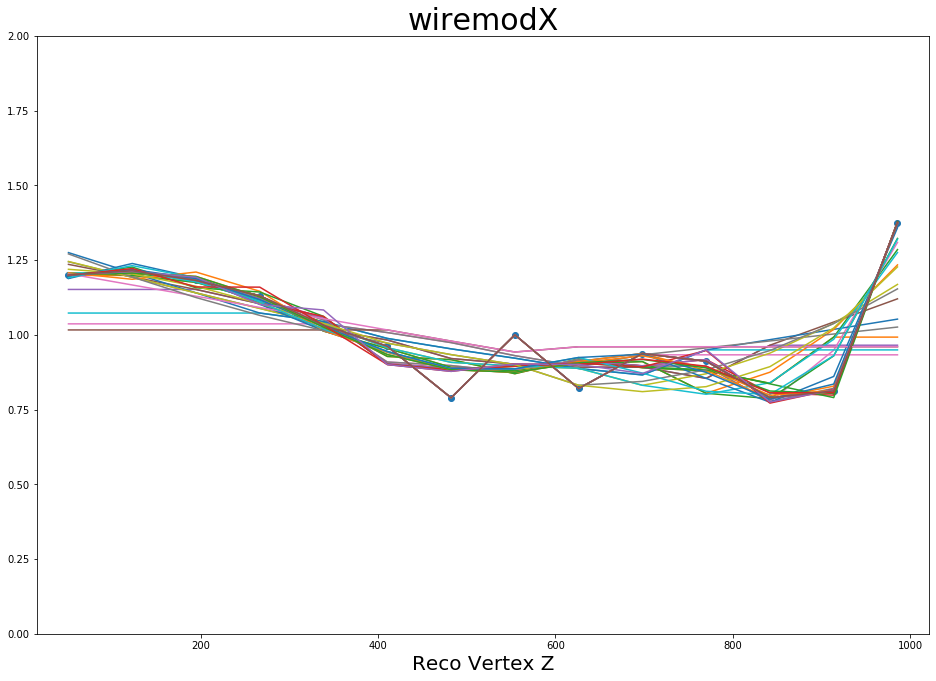

In [77]:
# The same thing with ratios

dvar = varListSel['Zreco']
nbins = 14
cov = np.zeros((nbins,nbins))
flatsys = 0.0

sysi = 0

myvardf = a_overlap_sys[sysi].query(s_cuts)
myvarcv = a_cv_sys[sysi].query(s_cuts_cv)
        
var_sys = myvardf[dvar.myname]
var_cv = myvarcv[dvar.myname+'_cv']
          
hCV,binedges = np.histogram(var_cv,bins=nbins,range=dvar.myrange)
h0,_ = np.histogram(var_sys,bins=nbins,range=dvar.myrange)
bincenters = np.diff(binedges)/2 + binedges[:-1]
truRat = np.true_divide(h0,hCV)

fig,ax = plt.subplots(figsize=(16,11))    
dvarLinspace = np.linspace(dvar.myrange[0],dvar.myrange[1],40)
plt.scatter(bincenters,np.true_divide(h0,hCV),label='Variation/CV')

# polyfit
for window_length in range(1,nbins-1,2):
    for deg in range(window_length):
        
        params = deg + 1
        sgRat = signal.savgol_filter(np.true_divide(h0,hCV), window_length, deg)
        h0_fit = sgRat*hCV
     
         # now calculate chi2 for fit
        yerr_rat = np.true_divide(np.sqrt(h0_fit),hCV)
        chi2_fit = np.power(np.true_divide(fRat(bincenters)-truRat,yerr_rat),2).sum()
        aic = chi2_fit + 2*params + 2*params*(params+1)/float(nbins-params-1)
        print('window_length',window_length,'degree:',deg,'chi2:',chi2_fit,'AIC:',aic)
        plt.plot(bincenters,sgRat,label='Sigfit (%i)'%polyterms)
    
ax.set_title(s_detsyslist[sysi],fontsize=30)
ax.set_xlabel(dvar.mylabel,fontsize=20)
#ax.legend(fontsize=15)
      
ax.set_xlim(dvar.myrange)
ax.set_ylim(0,2)

In [ ]:


if not os.path.exists(dumphole):
    os.makedirs(dumphole)

for dist in varlistSel:
    
    fig,ax = plt.subplots(figsize=(16,11))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, .75])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    hSys =  []
    
    for i in range(len(s_detsyslist)):
        var_sys = a_df_sys[i].query(s_cuts)[dist.myname]
        sys_scale = np.ones(len(var_sys))*totalscale/f_scaleslist[i]
        h0,_ = np.histogram(var_sys,range=dist.myrange,bins=dumpbins,weights=sys_scale)
        h1,_,_ = ax0.hist(var_sys,range=dist.myrange,bins=dumpbins,histtype='step',label=s_detsyslist[i]+' (%i)'%h0.sum(),linewidth=2,weights=sys_scale)
        hSys.append(h1)
    
    var_cv = df_cv.query(s_cuts)[dist.myname]
    cv_scale = np.ones(len(var_cv))*totalscale/scaleCV
    h0,_ = np.histogram(var_cv,range=dist.myrange,bins=dumpbins,weights=cv_scale)
    hCV,binedges,_ = ax0.hist(var_cv,range=dist.myrange,bins=dumpbins,histtype='step',label='CV (%i)'%h0.sum(),linewidth=3,color='black',linestyle='--',weights=cv_scale)       
    
    ax0.set_ylabel('Events in 5e19 POT',fontsize=20)
    ax0.set_xlabel(dist.mylabel,fontsize=25)
    ax0.set_title('BNB Overlay w/ Detsys',fontsize=15)
    ax0.set_xlim(dist.myrange)
    ax1.set_xlim(dist.myrange)
    ax1.set_ylim(0,2.5)
    ax0.legend(fontsize=15)
    
    for i in range(len(hSys)):
        ydots = np.true_divide(hSys[i],hCV,where=hCV!=0)
        xdots = binedges[:-1] + (binedges[1]-binedges[0])/float(len(hSys)) * i
        ax1.scatter(xdots,ydots)
    
    ax1.axhline(1,linestyle=':',color='maroon')
    
    for j in range(len(hCV)):
        ax1.axvline(binedges[j+1],linestyle=':',color='gray') 
    
    plt.savefig(dumphole+'/'+dist.myname+'.png')
    plt.close(fig)

## Smearing

In [51]:
dumphole = 'DetSysSmear'
dumpfolder = '../PlotDumps'

dumphole = '%s/%s'%(dumpfolder,dumphole)
if not os.path.exists(dumphole):
    os.makedirs(dumphole)
if not os.path.exists(dumphole):
    os.makedirs(dumphole)

for dist in varlistSel:

    fig,ax = plt.subplots(figsize=(16,11))
    binwidth = (dvar.myrange[1]-dvar.myrange[0])/float(14)
    myrange = (-3*binwidth,3*binwidth)
    nbins = 15

    for sysi in range(len(a_df_sys)):
        myvardf = a_overlap_sys[sysi].query(s_cuts)
        myvarcv = a_cv_sys[sysi].query(s_cuts_cv)
        
        var_sys = myvardf[dvar.myname]
        var_cv = myvarcv[dvar.myname+'_cv']
        
        h0,binedges,_ = plt.hist((var_cv-var_sys),bins=nbins,range=myrange,histtype='step',label=s_detsyslist[sysi],linewidth=3) 
    
    ax.axvline(binwidth,label='+1 Binwidth',linestyle=':')
    ax.axvline(-binwidth,label='-1 Binwidth',linestyle=':')
    ax.set_title('(CV - Detsys)',fontsize=30)
    ax.set_xlabel(r'$\Delta$'+dvar.mylabel,fontsize=20)
    ax.legend(fontsize=25)
    plt.savefig(dumphole+'/'+dvar.myname+'.png')
    plt.close(fig)
    

NameError: name 'varlistSel' is not defined

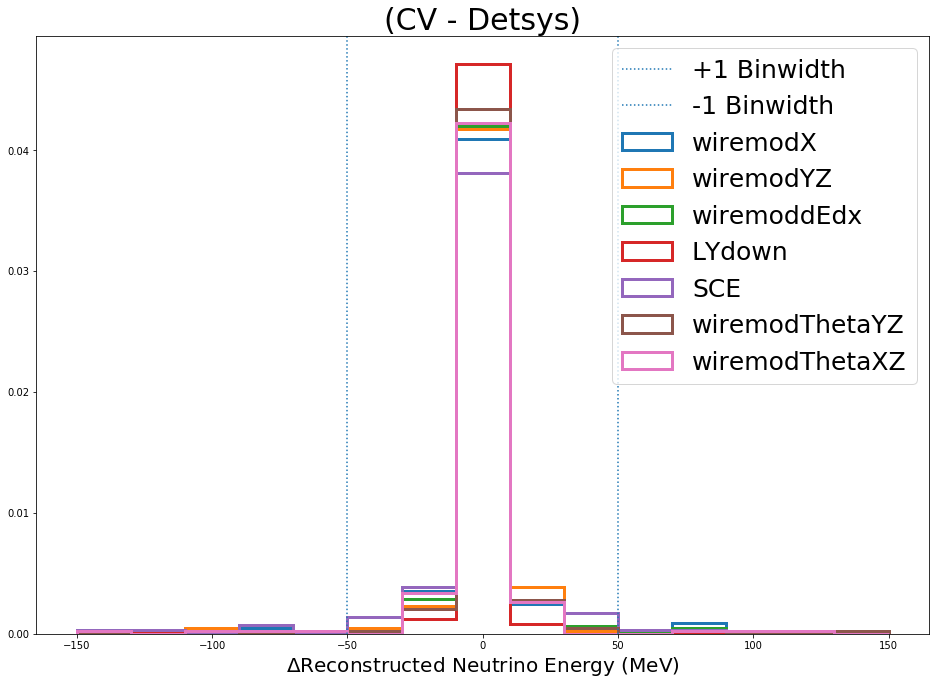

In [150]:
dvar = varListSel['Enu_1m1p']

fig,ax = plt.subplots(figsize=(16,11))
binwidth = (dvar.myrange[1]-dvar.myrange[0])/float(14)
myrange = (-3*binwidth,3*binwidth)
nbins = 15

for sysi in range(len(a_df_sys)):
    myvardf = a_overlap_sys[sysi].query(s_cuts)
    myvarcv = a_cv_sys[sysi].query(s_cuts_cv)
        
    var_sys = myvardf[dvar.myname]
    var_cv = myvarcv[dvar.myname+'_cv']
        
    h0,binedges,_ = plt.hist((var_cv-var_sys),bins=nbins,range=myrange,histtype='step',label=s_detsyslist[sysi],linewidth=3,density=1) 
    
ax.axvline(binwidth,label='+1 Binwidth',linestyle=':')
ax.axvline(-binwidth,label='-1 Binwidth',linestyle=':')
ax.set_title('(CV - Detsys)',fontsize=30)
ax.set_xlabel(r'$\Delta$'+dvar.mylabel,fontsize=20)
ax.legend(fontsize=25)

## Extras

In [83]:
dumpbins = 18
dumphole = '/home/dcianci/Downloads/detsys_may18_presel' # where are we dumping these?

if not os.path.exists(dumphole):
    os.makedirs(dumphole)

for dist in varlistSel:
    
    fig,ax = plt.subplots(figsize=(16,11))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, .75])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    hSys =  []
    
    for i in range(len(s_detsyslist)):
        var_sys = a_df_sys[i][dist.myname]
        sys_scale = np.ones(len(var_sys))*totalscale/f_scaleslist[i]
        h0,_ = np.histogram(var_sys,range=dist.myrange,bins=dumpbins,weights=sys_scale)
        h1,_,_ = ax0.hist(var_sys,range=dist.myrange,bins=dumpbins,histtype='step',label=s_detsyslist[i]+' (%.4f)'%h0.sum(),linewidth=2,weights=sys_scale)
        hSys.append(h1)
    
    var_cv = df_cv[dist.myname]
    cv_scale = np.ones(len(var_cv))*totalscale/scaleCV
    h0,_ = np.histogram(var_cv,range=dist.myrange,bins=dumpbins,weights=cv_scale)
    hCV,binedges,_ = ax0.hist(var_cv,range=dist.myrange,bins=dumpbins,histtype='step',label='CV (%.4f)'%h0.sum(),linewidth=3,color='black',linestyle='--',weights=cv_scale)
    
    ax0.set_ylabel('Events in 5e19 POT',fontsize=20)
    ax0.set_xlabel(dist.mylabel,fontsize=25)
    ax0.set_title('BNB Overlay w/ Detsys',fontsize=15)
    ax0.set_xlim(dist.myrange)
    ax1.set_xlim(dist.myrange)
    ax0.legend(fontsize=15)
    ax1.set_ylim(0,2.5)
    
    for i in range(len(hSys)):
        ydots = np.true_divide(hSys[i],hCV,where=hCV!=0)
        xdots = binedges[:-1] + (binedges[1]-binedges[0])/float(len(hSys)) * i
        ax1.scatter(xdots,ydots)
    
    ax1.axhline(1,linestyle=':',color='maroon')
    
    for j in range(len(hCV)):
        ax1.axvline(binedges[j+1],linestyle=':',color='gray') 
    
    plt.savefig(dumphole+'/'+dist.myname+'.png')
    plt.close(fig)

/home/dcianci/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/dcianci/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
